In [1]:
import datetime
import gym
import random
import numpy as np
import os
import itertools
import torch
from agent import Agent
from model import GaussianPolicy
import matplotlib.pyplot as plt


In [2]:
def grad_false(network):
    for param in network.parameters():
        param.requires_grad = False

In [3]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

def print_mean_reward(step, episode_rewards):
    if not episode_rewards:
        return

    t = min(50, len(episode_rewards))
    mean_reward = sum(episode_rewards[-t:]) / t
    print(f"step: {str(step).zfill(6)}, mean reward: {mean_reward:.2f}")
    return mean_reward

In [4]:
def print_mean_reward(step, episode_rewards):
    if not episode_rewards:
        return

    t = min(50, len(episode_rewards))
    mean_reward = sum(episode_rewards[-t:]) / t
    print(f"step: {str(step).zfill(6)}, mean reward: {mean_reward:.2f}")
    return mean_reward

def train(env_name, seed, iterations, batch_size, memory_size, min_steps, updates_per_step, folder, 
          hidden, lr, tau, target_update_int, alpha, gauss):
    rewards = []
    mean_rewards = []
    env = gym.make(env_name)
    #env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    iter = 0
    memory = ReplayMemory(memory_size, seed)
    agent = Agent(env.observation_space.shape[0],env.action_space,
                  0.97, tau, alpha,
                  gauss, target_update_int, True, hidden, lr, 'cpu')
    total_numsteps = 0
    updates = 0
    max_score = 0
    total_reward = 0
    while iter < iterations:
        episode_reward = 0
        episode_steps = 0
        done = False
        state, _ = env.reset(seed=seed)

        while not done:
            if min_steps > total_numsteps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)

            if len(memory) > batch_size:
                for i in range(updates_per_step):
                    critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, batch_size,
                                                                                                         updates)
                updates += 1
            next_state, reward, done, _, _ = env.step(action)  # Step

            episode_steps += 1
            total_numsteps += 1

            episode_reward += reward
            total_reward +=reward

            if episode_steps >= env._max_episode_steps:
                mask = 1
            else:
                mask = float(not done)
            memory.push(state, action, reward, next_state, mask)  # Append transition to memory
            state = next_state


            if episode_steps >= env._max_episode_steps:
                done = True
            #if total_numsteps % 100 == 0:
            #    print("step: ",total_numsteps,
            #        "episode_mean_reward: ", round(total_reward, 3)/total_numsteps)
        
        rewards.append(episode_reward)
        mean_rewards.append(total_reward/iter)
        if episode_reward > max_score:
            model_folder_path = "./"+ folder
            if not os.path.exists(model_folder_path):
                os.makedirs(model_folder_path)
            filename = os.path.join(model_folder_path, 'model.pth')
            torch.save(agent.policy, filename)
        print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {}".format(iter, total_numsteps,
                                                                                      episode_steps,
                                                                                      round(episode_reward, 2)))
        iter += 1

    fig = plt.figure()
    ax = plt.subplot(111)
    x = np.arange(iter)
    ax.plot(x, rewards, label="Reward")
    ax.plot(x, mean_rewards, label="Mean_reward")
    ax.legend()

    fig.savefig('./'+folder+'/plot.png')
    with open('./'+folder + '/reward.txt', 'w') as fp:
        for item in rewards:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

    with open('./'+folder + '/mean_reward.txt', 'w') as fp:
        for item in mean_rewards:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')


    env.close()

/var/folders/ts/81qmgdg936qcnxbxr487pm1m0000gn/T/ipykernel_20970/729232023.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  mean_rewards.append(total_reward/iter)


Episode: 0, total numsteps: 1000, episode steps: 1000, reward: -377.79
Episode: 1, total numsteps: 2000, episode steps: 1000, reward: -385.38
Episode: 2, total numsteps: 3000, episode steps: 1000, reward: -284.24
Episode: 3, total numsteps: 4000, episode steps: 1000, reward: -249.78
Episode: 4, total numsteps: 5000, episode steps: 1000, reward: -192.79
Episode: 5, total numsteps: 6000, episode steps: 1000, reward: 138.67
Episode: 6, total numsteps: 7000, episode steps: 1000, reward: 361.31
Episode: 7, total numsteps: 8000, episode steps: 1000, reward: 408.18
Episode: 8, total numsteps: 9000, episode steps: 1000, reward: 543.54
Episode: 9, total numsteps: 10000, episode steps: 1000, reward: 893.81
Episode: 10, total numsteps: 11000, episode steps: 1000, reward: 963.86
Episode: 11, total numsteps: 12000, episode steps: 1000, reward: 1057.81
Episode: 12, total numsteps: 13000, episode steps: 1000, reward: 1124.79
Episode: 13, total numsteps: 14000, episode steps: 1000, reward: 827.82
Epis

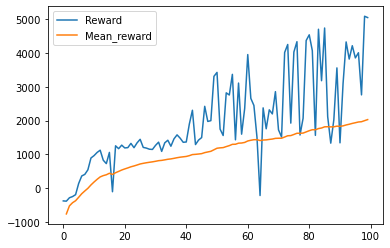

In [5]:
train('HalfCheetah-v4', 113, 100, 64, 10000, 2000, 1, 'cheetah', 256, 0.001, 0.005, 1, 0.2, 'Gaussian')

In [5]:
def run(env_name, folder, device, hidden ):

    env = gym.make(env_name, render_mode='human')
    device = torch.device(device)

    policy = GaussianPolicy(
        env.observation_space.shape[0],
        env.action_space.shape[0],
        hidden_dim=hidden).to(device)

    policy = torch.load('./' + folder + '/model.pth')
    grad_false(policy)

    def exploit(state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            _, _, action = policy.sample(state)
        return action.cpu().numpy().reshape(-1)

    state,_ = env.reset()
    episode_reward = 0.
    done = False
    while not done:
        env.render()
        action = exploit(state)
        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        state = next_state

In [ ]:
run('HalfCheetah-v4', 'cheetah', 'cpu', 256)

/var/folders/ts/81qmgdg936qcnxbxr487pm1m0000gn/T/ipykernel_20970/1664167519.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  mean_rewards.append(total_reward/iter)


Episode: 0, total numsteps: 4, episode steps: 4, reward: 35.96
Episode: 1, total numsteps: 11, episode steps: 7, reward: 63.42
Episode: 2, total numsteps: 18, episode steps: 7, reward: 63.81
Episode: 3, total numsteps: 25, episode steps: 7, reward: 64.01
Episode: 4, total numsteps: 31, episode steps: 6, reward: 54.1
Episode: 5, total numsteps: 39, episode steps: 8, reward: 72.55
Episode: 6, total numsteps: 44, episode steps: 5, reward: 45.16
Episode: 7, total numsteps: 50, episode steps: 6, reward: 54.05
Episode: 8, total numsteps: 56, episode steps: 6, reward: 54.2
Episode: 9, total numsteps: 66, episode steps: 10, reward: 91.61
Episode: 10, total numsteps: 74, episode steps: 8, reward: 72.78
Episode: 11, total numsteps: 86, episode steps: 12, reward: 110.21
Episode: 12, total numsteps: 93, episode steps: 7, reward: 63.76
Episode: 13, total numsteps: 98, episode steps: 5, reward: 45.12
Episode: 14, total numsteps: 102, episode steps: 4, reward: 36.04
Episode: 15, total numsteps: 107, 

Episode: 128, total numsteps: 801, episode steps: 4, reward: 36.04
Episode: 129, total numsteps: 807, episode steps: 6, reward: 54.58
Episode: 130, total numsteps: 815, episode steps: 8, reward: 73.22
Episode: 131, total numsteps: 819, episode steps: 4, reward: 35.55
Episode: 132, total numsteps: 827, episode steps: 8, reward: 72.82
Episode: 133, total numsteps: 831, episode steps: 4, reward: 36.09
Episode: 134, total numsteps: 836, episode steps: 5, reward: 44.89
Episode: 135, total numsteps: 843, episode steps: 7, reward: 63.86
Episode: 136, total numsteps: 850, episode steps: 7, reward: 63.88
Episode: 137, total numsteps: 856, episode steps: 6, reward: 54.45
Episode: 138, total numsteps: 865, episode steps: 9, reward: 82.08
Episode: 139, total numsteps: 874, episode steps: 9, reward: 82.05
Episode: 140, total numsteps: 880, episode steps: 6, reward: 54.31
Episode: 141, total numsteps: 886, episode steps: 6, reward: 54.47
Episode: 142, total numsteps: 893, episode steps: 7, reward: 6

Episode: 257, total numsteps: 1640, episode steps: 9, reward: 82.76
Episode: 258, total numsteps: 1645, episode steps: 5, reward: 44.9
Episode: 259, total numsteps: 1651, episode steps: 6, reward: 54.05
Episode: 260, total numsteps: 1658, episode steps: 7, reward: 63.7
Episode: 261, total numsteps: 1666, episode steps: 8, reward: 72.52
Episode: 262, total numsteps: 1670, episode steps: 4, reward: 36.17
Episode: 263, total numsteps: 1674, episode steps: 4, reward: 35.87
Episode: 264, total numsteps: 1683, episode steps: 9, reward: 82.77
Episode: 265, total numsteps: 1690, episode steps: 7, reward: 63.42
Episode: 266, total numsteps: 1695, episode steps: 5, reward: 45.02
Episode: 267, total numsteps: 1699, episode steps: 4, reward: 36.16
Episode: 268, total numsteps: 1703, episode steps: 4, reward: 36.21
Episode: 269, total numsteps: 1710, episode steps: 7, reward: 64.01
Episode: 270, total numsteps: 1714, episode steps: 4, reward: 36.19
Episode: 271, total numsteps: 1721, episode steps:

Episode: 377, total numsteps: 3537, episode steps: 28, reward: 259.64
Episode: 378, total numsteps: 3567, episode steps: 30, reward: 278.78
Episode: 379, total numsteps: 3594, episode steps: 27, reward: 250.61
Episode: 380, total numsteps: 3629, episode steps: 35, reward: 325.12
Episode: 381, total numsteps: 3661, episode steps: 32, reward: 297.37
Episode: 382, total numsteps: 3694, episode steps: 33, reward: 306.97
Episode: 383, total numsteps: 3724, episode steps: 30, reward: 278.66
Episode: 384, total numsteps: 3754, episode steps: 30, reward: 278.53
Episode: 385, total numsteps: 3787, episode steps: 33, reward: 306.39
Episode: 386, total numsteps: 3818, episode steps: 31, reward: 287.67
Episode: 387, total numsteps: 3849, episode steps: 31, reward: 287.73
Episode: 388, total numsteps: 3878, episode steps: 29, reward: 269.06
Episode: 389, total numsteps: 3910, episode steps: 32, reward: 297.57
Episode: 390, total numsteps: 3941, episode steps: 31, reward: 288.21
Episode: 391, total 

Episode: 495, total numsteps: 7559, episode steps: 35, reward: 325.08
Episode: 496, total numsteps: 7602, episode steps: 43, reward: 399.68
Episode: 497, total numsteps: 7650, episode steps: 48, reward: 447.24
Episode: 498, total numsteps: 7693, episode steps: 43, reward: 400.49
Episode: 499, total numsteps: 7734, episode steps: 41, reward: 381.42
Episode: 500, total numsteps: 7778, episode steps: 44, reward: 409.6
Episode: 501, total numsteps: 7828, episode steps: 50, reward: 465.64
Episode: 502, total numsteps: 7870, episode steps: 42, reward: 390.98
Episode: 503, total numsteps: 7909, episode steps: 39, reward: 362.56
Episode: 504, total numsteps: 7950, episode steps: 41, reward: 381.97
Episode: 505, total numsteps: 7994, episode steps: 44, reward: 409.64
Episode: 506, total numsteps: 8038, episode steps: 44, reward: 409.59
Episode: 507, total numsteps: 8081, episode steps: 43, reward: 400.54
Episode: 508, total numsteps: 8120, episode steps: 39, reward: 363.21
Episode: 509, total n

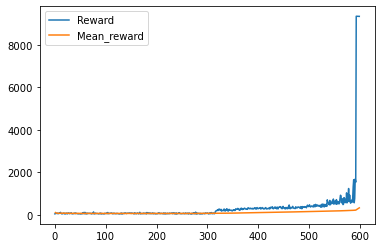

In [47]:
train('InvertedDoublePendulum-v4', 113, 600, 64, 10000, 2000, 1, 'invpend', 256, 0.001, 0.005, 1, 0.2, 'Gaussian')


In [ ]:
run('InvertedDoublePendulum-v4', 'invpend', 'cpu', 256)

/var/folders/ts/81qmgdg936qcnxbxr487pm1m0000gn/T/ipykernel_59163/1664167519.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  mean_rewards.append(total_reward/iter)


Episode: 0, total numsteps: 17, episode steps: 17, reward: 3.85
Episode: 1, total numsteps: 50, episode steps: 33, reward: 6.09
Episode: 2, total numsteps: 74, episode steps: 24, reward: 4.03
Episode: 3, total numsteps: 85, episode steps: 11, reward: -0.24
Episode: 4, total numsteps: 111, episode steps: 26, reward: 7.83
Episode: 5, total numsteps: 145, episode steps: 34, reward: -1.63
Episode: 6, total numsteps: 179, episode steps: 34, reward: -8.81
Episode: 7, total numsteps: 199, episode steps: 20, reward: 6.73
Episode: 8, total numsteps: 235, episode steps: 36, reward: 2.71
Episode: 9, total numsteps: 252, episode steps: 17, reward: 0.34
Episode: 10, total numsteps: 277, episode steps: 25, reward: 6.66
Episode: 11, total numsteps: 294, episode steps: 17, reward: 1.33
Episode: 12, total numsteps: 309, episode steps: 15, reward: 3.65
Episode: 13, total numsteps: 352, episode steps: 43, reward: 20.12
Episode: 14, total numsteps: 398, episode steps: 46, reward: 20.84
Episode: 15, total 

Episode: 124, total numsteps: 2628, episode steps: 23, reward: -7.91
Episode: 125, total numsteps: 2647, episode steps: 19, reward: 1.3
Episode: 126, total numsteps: 2668, episode steps: 21, reward: -1.74
Episode: 127, total numsteps: 2694, episode steps: 26, reward: 2.26
Episode: 128, total numsteps: 2708, episode steps: 14, reward: 1.53
Episode: 129, total numsteps: 2732, episode steps: 24, reward: 4.77
Episode: 130, total numsteps: 2740, episode steps: 8, reward: -2.78
Episode: 131, total numsteps: 2751, episode steps: 11, reward: -2.42
Episode: 132, total numsteps: 2784, episode steps: 33, reward: 8.59
Episode: 133, total numsteps: 2814, episode steps: 30, reward: 9.67
Episode: 134, total numsteps: 2834, episode steps: 20, reward: 0.86
Episode: 135, total numsteps: 2853, episode steps: 19, reward: 4.24
Episode: 136, total numsteps: 2879, episode steps: 26, reward: 0.97
Episode: 137, total numsteps: 2898, episode steps: 19, reward: 4.51
Episode: 138, total numsteps: 2923, episode st

Episode: 244, total numsteps: 5149, episode steps: 13, reward: -1.55
Episode: 245, total numsteps: 5158, episode steps: 9, reward: -2.65
Episode: 246, total numsteps: 5177, episode steps: 19, reward: -1.54
Episode: 247, total numsteps: 5211, episode steps: 34, reward: -1.71
Episode: 248, total numsteps: 5226, episode steps: 15, reward: 1.13
Episode: 249, total numsteps: 5249, episode steps: 23, reward: 7.9
Episode: 250, total numsteps: 5270, episode steps: 21, reward: 0.85
Episode: 251, total numsteps: 5279, episode steps: 9, reward: -1.66
Episode: 252, total numsteps: 5297, episode steps: 18, reward: -9.59
Episode: 253, total numsteps: 5318, episode steps: 21, reward: -5.48
Episode: 254, total numsteps: 5358, episode steps: 40, reward: -5.15
Episode: 255, total numsteps: 5396, episode steps: 38, reward: 11.82
Episode: 256, total numsteps: 5410, episode steps: 14, reward: -3.17
Episode: 257, total numsteps: 5424, episode steps: 14, reward: 0.02
Episode: 258, total numsteps: 5451, episo

Episode: 365, total numsteps: 7695, episode steps: 47, reward: 15.45
Episode: 366, total numsteps: 7716, episode steps: 21, reward: 3.77
Episode: 367, total numsteps: 7754, episode steps: 38, reward: 16.47
Episode: 368, total numsteps: 7781, episode steps: 27, reward: 14.44
Episode: 369, total numsteps: 7806, episode steps: 25, reward: 4.33
Episode: 370, total numsteps: 7828, episode steps: 22, reward: 0.7
Episode: 371, total numsteps: 7898, episode steps: 70, reward: 28.98
Episode: 372, total numsteps: 7940, episode steps: 42, reward: 10.08
Episode: 373, total numsteps: 7964, episode steps: 24, reward: 10.23
Episode: 374, total numsteps: 7989, episode steps: 25, reward: 0.05
Episode: 375, total numsteps: 8014, episode steps: 25, reward: -0.44
Episode: 376, total numsteps: 8036, episode steps: 22, reward: 6.11
Episode: 377, total numsteps: 8049, episode steps: 13, reward: 0.84
Episode: 378, total numsteps: 8078, episode steps: 29, reward: 3.15
Episode: 379, total numsteps: 8090, episod

Episode: 486, total numsteps: 11392, episode steps: 27, reward: 5.0
Episode: 487, total numsteps: 11420, episode steps: 28, reward: 10.24
Episode: 488, total numsteps: 11495, episode steps: 75, reward: -15.83
Episode: 489, total numsteps: 11563, episode steps: 68, reward: -23.32
Episode: 490, total numsteps: 11676, episode steps: 113, reward: -33.6
Episode: 491, total numsteps: 11754, episode steps: 78, reward: -27.71
Episode: 492, total numsteps: 11812, episode steps: 58, reward: -3.86
Episode: 493, total numsteps: 11873, episode steps: 61, reward: 3.12
Episode: 494, total numsteps: 11956, episode steps: 83, reward: -21.08
Episode: 495, total numsteps: 12131, episode steps: 175, reward: 62.89
Episode: 496, total numsteps: 12233, episode steps: 102, reward: -1.76
Episode: 497, total numsteps: 12380, episode steps: 147, reward: 159.47
Episode: 498, total numsteps: 12503, episode steps: 123, reward: -11.26
Episode: 499, total numsteps: 12594, episode steps: 91, reward: 12.19
Episode: 500

Episode: 601, total numsteps: 33206, episode steps: 158, reward: 294.44
Episode: 602, total numsteps: 33349, episode steps: 143, reward: 261.48
Episode: 603, total numsteps: 33684, episode steps: 335, reward: 237.92
Episode: 604, total numsteps: 33811, episode steps: 127, reward: 232.03
Episode: 605, total numsteps: 33974, episode steps: 163, reward: 298.56
Episode: 606, total numsteps: 34241, episode steps: 267, reward: 413.98
Episode: 607, total numsteps: 34474, episode steps: 233, reward: 436.21
Episode: 608, total numsteps: 34653, episode steps: 179, reward: 322.42
Episode: 609, total numsteps: 34843, episode steps: 190, reward: 382.53
Episode: 610, total numsteps: 35017, episode steps: 174, reward: 347.85
Episode: 611, total numsteps: 35169, episode steps: 152, reward: 326.37
Episode: 612, total numsteps: 35324, episode steps: 155, reward: 224.62
Episode: 613, total numsteps: 35512, episode steps: 188, reward: 128.54
Episode: 614, total numsteps: 35649, episode steps: 137, reward:

Episode: 716, total numsteps: 51343, episode steps: 166, reward: 357.88
Episode: 717, total numsteps: 51461, episode steps: 118, reward: 214.85
Episode: 718, total numsteps: 51634, episode steps: 173, reward: 340.54
Episode: 719, total numsteps: 51937, episode steps: 303, reward: 372.11
Episode: 720, total numsteps: 52128, episode steps: 191, reward: 299.38
Episode: 721, total numsteps: 52639, episode steps: 511, reward: 653.66
Episode: 722, total numsteps: 52756, episode steps: 117, reward: 231.02
Episode: 723, total numsteps: 52991, episode steps: 235, reward: 231.61
Episode: 724, total numsteps: 53151, episode steps: 160, reward: 335.25
Episode: 725, total numsteps: 53316, episode steps: 165, reward: 337.06
Episode: 726, total numsteps: 53473, episode steps: 157, reward: 327.65
Episode: 727, total numsteps: 53657, episode steps: 184, reward: 390.92
Episode: 728, total numsteps: 53828, episode steps: 171, reward: 350.38
Episode: 729, total numsteps: 54014, episode steps: 186, reward:

Episode: 831, total numsteps: 67886, episode steps: 105, reward: 240.19
Episode: 832, total numsteps: 67987, episode steps: 101, reward: 214.51
Episode: 833, total numsteps: 68101, episode steps: 114, reward: 247.88
Episode: 834, total numsteps: 68245, episode steps: 144, reward: 318.71
Episode: 835, total numsteps: 68348, episode steps: 103, reward: 215.67
Episode: 836, total numsteps: 68498, episode steps: 150, reward: 326.52
Episode: 837, total numsteps: 68669, episode steps: 171, reward: 363.98
Episode: 838, total numsteps: 68809, episode steps: 140, reward: 313.32
Episode: 839, total numsteps: 68954, episode steps: 145, reward: 324.44
Episode: 840, total numsteps: 69085, episode steps: 131, reward: 304.38
Episode: 841, total numsteps: 69198, episode steps: 113, reward: 247.43
Episode: 842, total numsteps: 69287, episode steps: 89, reward: 188.3
Episode: 843, total numsteps: 69391, episode steps: 104, reward: 216.0
Episode: 844, total numsteps: 69526, episode steps: 135, reward: 30

Episode: 946, total numsteps: 84304, episode steps: 70, reward: 112.31
Episode: 947, total numsteps: 84456, episode steps: 152, reward: 388.23
Episode: 948, total numsteps: 84525, episode steps: 69, reward: 122.95
Episode: 949, total numsteps: 84596, episode steps: 71, reward: 119.43
Episode: 950, total numsteps: 84748, episode steps: 152, reward: 405.58
Episode: 951, total numsteps: 84865, episode steps: 117, reward: 274.17
Episode: 952, total numsteps: 84946, episode steps: 81, reward: 135.64
Episode: 953, total numsteps: 85076, episode steps: 130, reward: 317.08
Episode: 954, total numsteps: 85292, episode steps: 216, reward: 633.92
Episode: 955, total numsteps: 85468, episode steps: 176, reward: 482.66
Episode: 956, total numsteps: 85636, episode steps: 168, reward: 457.96
Episode: 957, total numsteps: 85792, episode steps: 156, reward: 387.16
Episode: 958, total numsteps: 85955, episode steps: 163, reward: 424.82
Episode: 959, total numsteps: 86109, episode steps: 154, reward: 358

Episode: 1060, total numsteps: 101504, episode steps: 89, reward: 174.3
Episode: 1061, total numsteps: 101639, episode steps: 135, reward: 381.54
Episode: 1062, total numsteps: 101833, episode steps: 194, reward: 403.86
Episode: 1063, total numsteps: 102022, episode steps: 189, reward: 361.11
Episode: 1064, total numsteps: 102227, episode steps: 205, reward: 491.99
Episode: 1065, total numsteps: 102302, episode steps: 75, reward: 67.37
Episode: 1066, total numsteps: 102486, episode steps: 184, reward: 439.05
Episode: 1067, total numsteps: 102685, episode steps: 199, reward: 443.84
Episode: 1068, total numsteps: 102878, episode steps: 193, reward: 484.73
Episode: 1069, total numsteps: 103050, episode steps: 172, reward: 450.53
Episode: 1070, total numsteps: 103343, episode steps: 293, reward: 545.97
Episode: 1071, total numsteps: 103563, episode steps: 220, reward: 480.21
Episode: 1072, total numsteps: 103819, episode steps: 256, reward: 502.99
Episode: 1073, total numsteps: 104041, epi

Episode: 1172, total numsteps: 116304, episode steps: 77, reward: 155.17
Episode: 1173, total numsteps: 116372, episode steps: 68, reward: 119.83
Episode: 1174, total numsteps: 116436, episode steps: 64, reward: 108.39
Episode: 1175, total numsteps: 116501, episode steps: 65, reward: 108.32
Episode: 1176, total numsteps: 116589, episode steps: 88, reward: 165.62
Episode: 1177, total numsteps: 116730, episode steps: 141, reward: 367.61
Episode: 1178, total numsteps: 116949, episode steps: 219, reward: 615.7
Episode: 1179, total numsteps: 117032, episode steps: 83, reward: 155.66
Episode: 1180, total numsteps: 117114, episode steps: 82, reward: 164.9
Episode: 1181, total numsteps: 117240, episode steps: 126, reward: 315.48
Episode: 1182, total numsteps: 117310, episode steps: 70, reward: 118.68
Episode: 1183, total numsteps: 117475, episode steps: 165, reward: 453.5
Episode: 1184, total numsteps: 117574, episode steps: 99, reward: 221.96
Episode: 1185, total numsteps: 117637, episode ste

Episode: 1285, total numsteps: 131399, episode steps: 40, reward: 32.87
Episode: 1286, total numsteps: 131575, episode steps: 176, reward: 481.01
Episode: 1287, total numsteps: 131625, episode steps: 50, reward: 61.86
Episode: 1288, total numsteps: 131727, episode steps: 102, reward: 226.64
Episode: 1289, total numsteps: 131815, episode steps: 88, reward: 179.71
Episode: 1290, total numsteps: 131842, episode steps: 27, reward: 5.02
Episode: 1291, total numsteps: 131865, episode steps: 23, reward: -0.21
Episode: 1292, total numsteps: 131889, episode steps: 24, reward: 1.42
Episode: 1293, total numsteps: 132027, episode steps: 138, reward: 325.98
Episode: 1294, total numsteps: 132210, episode steps: 183, reward: 531.44
Episode: 1295, total numsteps: 132501, episode steps: 291, reward: 816.82
Episode: 1296, total numsteps: 132733, episode steps: 232, reward: 738.22
Episode: 1297, total numsteps: 132819, episode steps: 86, reward: -38.42
Episode: 1298, total numsteps: 132937, episode steps

Episode: 1397, total numsteps: 146836, episode steps: 67, reward: 112.8
Episode: 1398, total numsteps: 146903, episode steps: 67, reward: 108.42
Episode: 1399, total numsteps: 146991, episode steps: 88, reward: 159.75
Episode: 1400, total numsteps: 147166, episode steps: 175, reward: 455.24
Episode: 1401, total numsteps: 147300, episode steps: 134, reward: 346.77
Episode: 1402, total numsteps: 147560, episode steps: 260, reward: 798.24
Episode: 1403, total numsteps: 147686, episode steps: 126, reward: 320.09
Episode: 1404, total numsteps: 148094, episode steps: 408, reward: 1264.88
Episode: 1405, total numsteps: 148177, episode steps: 83, reward: 160.19
Episode: 1406, total numsteps: 148269, episode steps: 92, reward: 193.37
Episode: 1407, total numsteps: 148405, episode steps: 136, reward: 390.8
Episode: 1408, total numsteps: 148555, episode steps: 150, reward: 415.9
Episode: 1409, total numsteps: 148729, episode steps: 174, reward: 520.57
Episode: 1410, total numsteps: 148951, episod

Episode: 1510, total numsteps: 165186, episode steps: 258, reward: 707.19
Episode: 1511, total numsteps: 165411, episode steps: 225, reward: 624.49
Episode: 1512, total numsteps: 165860, episode steps: 449, reward: 1332.7
Episode: 1513, total numsteps: 165996, episode steps: 136, reward: 347.14
Episode: 1514, total numsteps: 166098, episode steps: 102, reward: 244.97
Episode: 1515, total numsteps: 166473, episode steps: 375, reward: 1059.03
Episode: 1516, total numsteps: 166762, episode steps: 289, reward: 959.55
Episode: 1517, total numsteps: 167037, episode steps: 275, reward: 896.35
Episode: 1518, total numsteps: 167351, episode steps: 314, reward: 1025.01
Episode: 1519, total numsteps: 167603, episode steps: 252, reward: 888.05
Episode: 1520, total numsteps: 167903, episode steps: 300, reward: 1039.78
Episode: 1521, total numsteps: 168099, episode steps: 196, reward: 657.67
Episode: 1522, total numsteps: 168195, episode steps: 96, reward: 219.21
Episode: 1523, total numsteps: 16826

Episode: 1621, total numsteps: 186865, episode steps: 65, reward: 96.38
Episode: 1622, total numsteps: 186944, episode steps: 79, reward: 161.09
Episode: 1623, total numsteps: 187077, episode steps: 133, reward: 392.21
Episode: 1624, total numsteps: 187145, episode steps: 68, reward: 118.68
Episode: 1625, total numsteps: 187211, episode steps: 66, reward: 108.75
Episode: 1626, total numsteps: 187296, episode steps: 85, reward: 172.72
Episode: 1627, total numsteps: 187407, episode steps: 111, reward: 283.53
Episode: 1628, total numsteps: 187519, episode steps: 112, reward: 284.27
Episode: 1629, total numsteps: 187591, episode steps: 72, reward: 119.65
Episode: 1630, total numsteps: 187663, episode steps: 72, reward: 111.49
Episode: 1631, total numsteps: 187854, episode steps: 191, reward: 632.13
Episode: 1632, total numsteps: 188126, episode steps: 272, reward: 906.16
Episode: 1633, total numsteps: 188339, episode steps: 213, reward: 748.0
Episode: 1634, total numsteps: 188483, episode 

Episode: 1732, total numsteps: 210040, episode steps: 182, reward: 570.9
Episode: 1733, total numsteps: 210324, episode steps: 284, reward: 1047.77
Episode: 1734, total numsteps: 210457, episode steps: 133, reward: 397.75
Episode: 1735, total numsteps: 210524, episode steps: 67, reward: 118.36
Episode: 1736, total numsteps: 210595, episode steps: 71, reward: 117.57
Episode: 1737, total numsteps: 211210, episode steps: 615, reward: 2507.45
Episode: 1738, total numsteps: 211384, episode steps: 174, reward: 526.91
Episode: 1739, total numsteps: 211524, episode steps: 140, reward: 411.02
Episode: 1740, total numsteps: 211691, episode steps: 167, reward: 506.83
Episode: 1741, total numsteps: 212136, episode steps: 445, reward: 1868.54
Episode: 1742, total numsteps: 212322, episode steps: 186, reward: 611.83
Episode: 1743, total numsteps: 212481, episode steps: 159, reward: 393.78
Episode: 1744, total numsteps: 212788, episode steps: 307, reward: 1145.07
Episode: 1745, total numsteps: 213073

Episode: 1843, total numsteps: 234130, episode steps: 281, reward: 1001.31
Episode: 1844, total numsteps: 234402, episode steps: 272, reward: 1070.57
Episode: 1845, total numsteps: 234611, episode steps: 209, reward: 678.78
Episode: 1846, total numsteps: 234751, episode steps: 140, reward: 376.74
Episode: 1847, total numsteps: 235142, episode steps: 391, reward: 1612.06
Episode: 1848, total numsteps: 235213, episode steps: 71, reward: 130.24
Episode: 1849, total numsteps: 235294, episode steps: 81, reward: 152.53
Episode: 1850, total numsteps: 235524, episode steps: 230, reward: 758.69
Episode: 1851, total numsteps: 236082, episode steps: 558, reward: 2297.29
Episode: 1852, total numsteps: 236343, episode steps: 261, reward: 896.87
Episode: 1853, total numsteps: 236704, episode steps: 361, reward: 1367.86
Episode: 1854, total numsteps: 237005, episode steps: 301, reward: 1114.52
Episode: 1855, total numsteps: 237794, episode steps: 789, reward: 3412.99
Episode: 1856, total numsteps: 23

Episode: 1954, total numsteps: 259866, episode steps: 531, reward: 2293.12
Episode: 1955, total numsteps: 260112, episode steps: 246, reward: 844.3
Episode: 1956, total numsteps: 260660, episode steps: 548, reward: 2158.49
Episode: 1957, total numsteps: 260759, episode steps: 99, reward: 220.7
Episode: 1958, total numsteps: 261257, episode steps: 498, reward: 2150.56
Episode: 1959, total numsteps: 261540, episode steps: 283, reward: 1060.49
Episode: 1960, total numsteps: 262087, episode steps: 547, reward: 2163.34
Episode: 1961, total numsteps: 262335, episode steps: 248, reward: 915.49
Episode: 1962, total numsteps: 262805, episode steps: 470, reward: 2030.49
Episode: 1963, total numsteps: 263613, episode steps: 808, reward: 3384.41
Episode: 1964, total numsteps: 264101, episode steps: 488, reward: 1994.61
Episode: 1965, total numsteps: 264611, episode steps: 510, reward: 2172.48
Episode: 1966, total numsteps: 265323, episode steps: 712, reward: 2850.42
Episode: 1967, total numsteps: 

Episode: 2064, total numsteps: 300123, episode steps: 256, reward: 924.88
Episode: 2065, total numsteps: 300445, episode steps: 322, reward: 1280.87
Episode: 2066, total numsteps: 300512, episode steps: 67, reward: 112.74
Episode: 2067, total numsteps: 301022, episode steps: 510, reward: 2175.3
Episode: 2068, total numsteps: 301340, episode steps: 318, reward: 1230.22
Episode: 2069, total numsteps: 301654, episode steps: 314, reward: 1232.53
Episode: 2070, total numsteps: 301800, episode steps: 146, reward: 394.75
Episode: 2071, total numsteps: 301930, episode steps: 130, reward: 373.32
Episode: 2072, total numsteps: 302064, episode steps: 134, reward: 375.73
Episode: 2073, total numsteps: 302328, episode steps: 264, reward: 1003.87
Episode: 2074, total numsteps: 302582, episode steps: 254, reward: 958.97
Episode: 2075, total numsteps: 302876, episode steps: 294, reward: 1113.18
Episode: 2076, total numsteps: 303146, episode steps: 270, reward: 986.97
Episode: 2077, total numsteps: 303

Episode: 2175, total numsteps: 331303, episode steps: 176, reward: 573.78
Episode: 2176, total numsteps: 331764, episode steps: 461, reward: 2017.87
Episode: 2177, total numsteps: 332011, episode steps: 247, reward: 900.83
Episode: 2178, total numsteps: 332637, episode steps: 626, reward: 2854.44
Episode: 2179, total numsteps: 332834, episode steps: 197, reward: 660.05
Episode: 2180, total numsteps: 333101, episode steps: 267, reward: 1048.45
Episode: 2181, total numsteps: 333559, episode steps: 458, reward: 1933.22
Episode: 2182, total numsteps: 333802, episode steps: 243, reward: 877.9
Episode: 2183, total numsteps: 334723, episode steps: 921, reward: 4367.28
Episode: 2184, total numsteps: 335148, episode steps: 425, reward: 1813.05
Episode: 2185, total numsteps: 335564, episode steps: 416, reward: 1674.33
Episode: 2186, total numsteps: 335664, episode steps: 100, reward: 233.15
Episode: 2187, total numsteps: 335749, episode steps: 85, reward: 166.66
Episode: 2188, total numsteps: 33

Episode: 2286, total numsteps: 358060, episode steps: 324, reward: 1294.02
Episode: 2287, total numsteps: 358187, episode steps: 127, reward: 331.16
Episode: 2288, total numsteps: 358460, episode steps: 273, reward: 979.17
Episode: 2289, total numsteps: 358654, episode steps: 194, reward: 689.03
Episode: 2290, total numsteps: 358830, episode steps: 176, reward: 597.51
Episode: 2291, total numsteps: 359049, episode steps: 219, reward: 760.99
Episode: 2292, total numsteps: 359400, episode steps: 351, reward: 1399.07
Episode: 2293, total numsteps: 359662, episode steps: 262, reward: 903.12
Episode: 2294, total numsteps: 359856, episode steps: 194, reward: 635.9
Episode: 2295, total numsteps: 360209, episode steps: 353, reward: 1355.33
Episode: 2296, total numsteps: 360361, episode steps: 152, reward: 432.76
Episode: 2297, total numsteps: 360440, episode steps: 79, reward: 155.59
Episode: 2298, total numsteps: 360555, episode steps: 115, reward: 302.69
Episode: 2299, total numsteps: 360698

Episode: 2397, total numsteps: 390306, episode steps: 169, reward: 523.38
Episode: 2398, total numsteps: 390538, episode steps: 232, reward: 836.66
Episode: 2399, total numsteps: 390871, episode steps: 333, reward: 1225.2
Episode: 2400, total numsteps: 390960, episode steps: 89, reward: 187.59
Episode: 2401, total numsteps: 391153, episode steps: 193, reward: 617.96
Episode: 2402, total numsteps: 391565, episode steps: 412, reward: 1707.73
Episode: 2403, total numsteps: 391752, episode steps: 187, reward: 609.47
Episode: 2404, total numsteps: 392029, episode steps: 277, reward: 979.73
Episode: 2405, total numsteps: 392528, episode steps: 499, reward: 2184.94
Episode: 2406, total numsteps: 392600, episode steps: 72, reward: 127.93
Episode: 2407, total numsteps: 392685, episode steps: 85, reward: 170.7
Episode: 2408, total numsteps: 393010, episode steps: 325, reward: 1274.34
Episode: 2409, total numsteps: 393470, episode steps: 460, reward: 1961.92
Episode: 2410, total numsteps: 393551,

Episode: 2508, total numsteps: 419955, episode steps: 342, reward: 1334.86
Episode: 2509, total numsteps: 420059, episode steps: 104, reward: 261.02
Episode: 2510, total numsteps: 420439, episode steps: 380, reward: 1556.37
Episode: 2511, total numsteps: 420533, episode steps: 94, reward: 204.93
Episode: 2512, total numsteps: 420758, episode steps: 225, reward: 750.78
Episode: 2513, total numsteps: 420854, episode steps: 96, reward: 201.35
Episode: 2514, total numsteps: 421058, episode steps: 204, reward: 683.09
Episode: 2515, total numsteps: 421213, episode steps: 155, reward: 449.92
Episode: 2516, total numsteps: 421544, episode steps: 331, reward: 1332.11
Episode: 2517, total numsteps: 421837, episode steps: 293, reward: 1156.21
Episode: 2518, total numsteps: 422173, episode steps: 336, reward: 1321.06
Episode: 2519, total numsteps: 422288, episode steps: 115, reward: 297.75
Episode: 2520, total numsteps: 422541, episode steps: 253, reward: 937.11
Episode: 2521, total numsteps: 4226

Episode: 2620, total numsteps: 433039, episode steps: 24, reward: -7.47
Episode: 2621, total numsteps: 433062, episode steps: 23, reward: -10.2
Episode: 2622, total numsteps: 433112, episode steps: 50, reward: 16.56
Episode: 2623, total numsteps: 433171, episode steps: 59, reward: -5.44
Episode: 2624, total numsteps: 433230, episode steps: 59, reward: -23.14
Episode: 2625, total numsteps: 433392, episode steps: 162, reward: -92.37
Episode: 2626, total numsteps: 433467, episode steps: 75, reward: -18.51
Episode: 2627, total numsteps: 433512, episode steps: 45, reward: -10.82
Episode: 2628, total numsteps: 433557, episode steps: 45, reward: -10.72
Episode: 2629, total numsteps: 433616, episode steps: 59, reward: -10.59
Episode: 2630, total numsteps: 433657, episode steps: 41, reward: -7.85
Episode: 2631, total numsteps: 433694, episode steps: 37, reward: -8.05
Episode: 2632, total numsteps: 433735, episode steps: 41, reward: -6.6
Episode: 2633, total numsteps: 433790, episode steps: 55, 

Episode: 2732, total numsteps: 456963, episode steps: 70, reward: 120.37
Episode: 2733, total numsteps: 457226, episode steps: 263, reward: 1015.06
Episode: 2734, total numsteps: 457398, episode steps: 172, reward: 571.33
Episode: 2735, total numsteps: 457854, episode steps: 456, reward: 2029.11
Episode: 2736, total numsteps: 458107, episode steps: 253, reward: 922.68
Episode: 2737, total numsteps: 458205, episode steps: 98, reward: 220.56
Episode: 2738, total numsteps: 458322, episode steps: 117, reward: 299.35
Episode: 2739, total numsteps: 458508, episode steps: 186, reward: 609.99
Episode: 2740, total numsteps: 458751, episode steps: 243, reward: 897.96
Episode: 2741, total numsteps: 459102, episode steps: 351, reward: 1411.19
Episode: 2742, total numsteps: 459231, episode steps: 129, reward: 371.19
Episode: 2743, total numsteps: 459362, episode steps: 131, reward: 352.06
Episode: 2744, total numsteps: 459438, episode steps: 76, reward: 131.41
Episode: 2745, total numsteps: 459510,

Episode: 2843, total numsteps: 489269, episode steps: 232, reward: 838.4
Episode: 2844, total numsteps: 489537, episode steps: 268, reward: 949.03
Episode: 2845, total numsteps: 489859, episode steps: 322, reward: 1296.96
Episode: 2846, total numsteps: 490188, episode steps: 329, reward: 1280.71
Episode: 2847, total numsteps: 490427, episode steps: 239, reward: 873.08
Episode: 2848, total numsteps: 490689, episode steps: 262, reward: 930.27
Episode: 2849, total numsteps: 491066, episode steps: 377, reward: 1581.79
Episode: 2850, total numsteps: 491247, episode steps: 181, reward: 566.29
Episode: 2851, total numsteps: 491931, episode steps: 684, reward: 3141.21
Episode: 2852, total numsteps: 492276, episode steps: 345, reward: 1400.94
Episode: 2853, total numsteps: 492401, episode steps: 125, reward: 343.0
Episode: 2854, total numsteps: 493011, episode steps: 610, reward: 2776.16
Episode: 2855, total numsteps: 493284, episode steps: 273, reward: 1033.59
Episode: 2856, total numsteps: 49

Episode: 2953, total numsteps: 524927, episode steps: 323, reward: 1281.41
Episode: 2954, total numsteps: 525175, episode steps: 248, reward: 915.84
Episode: 2955, total numsteps: 525502, episode steps: 327, reward: 1280.17
Episode: 2956, total numsteps: 525839, episode steps: 337, reward: 1387.07
Episode: 2957, total numsteps: 526385, episode steps: 546, reward: 2323.49
Episode: 2958, total numsteps: 526552, episode steps: 167, reward: 521.15
Episode: 2959, total numsteps: 527275, episode steps: 723, reward: 3411.58
Episode: 2960, total numsteps: 527410, episode steps: 135, reward: 362.7
Episode: 2961, total numsteps: 527721, episode steps: 311, reward: 1196.29
Episode: 2962, total numsteps: 527990, episode steps: 269, reward: 989.55
Episode: 2963, total numsteps: 528337, episode steps: 347, reward: 1263.43
Episode: 2964, total numsteps: 528454, episode steps: 117, reward: 270.62
Episode: 2965, total numsteps: 528525, episode steps: 71, reward: 126.05
Episode: 2966, total numsteps: 52

Episode: 3064, total numsteps: 555771, episode steps: 287, reward: 1111.51
Episode: 3065, total numsteps: 556034, episode steps: 263, reward: 1017.46
Episode: 3066, total numsteps: 556387, episode steps: 353, reward: 1493.33
Episode: 3067, total numsteps: 556562, episode steps: 175, reward: 532.12
Episode: 3068, total numsteps: 556749, episode steps: 187, reward: 608.37
Episode: 3069, total numsteps: 556955, episode steps: 206, reward: 735.87
Episode: 3070, total numsteps: 557147, episode steps: 192, reward: 634.54
Episode: 3071, total numsteps: 557408, episode steps: 261, reward: 981.59
Episode: 3072, total numsteps: 557606, episode steps: 198, reward: 663.39
Episode: 3073, total numsteps: 557900, episode steps: 294, reward: 1112.29
Episode: 3074, total numsteps: 558171, episode steps: 271, reward: 1058.62
Episode: 3075, total numsteps: 558413, episode steps: 242, reward: 895.49
Episode: 3076, total numsteps: 558615, episode steps: 202, reward: 690.87
Episode: 3077, total numsteps: 55

Episode: 3174, total numsteps: 590106, episode steps: 429, reward: 1825.27
Episode: 3175, total numsteps: 590494, episode steps: 388, reward: 1665.92
Episode: 3176, total numsteps: 590802, episode steps: 308, reward: 1217.57
Episode: 3177, total numsteps: 591363, episode steps: 561, reward: 2511.88
Episode: 3178, total numsteps: 591886, episode steps: 523, reward: 2267.41
Episode: 3179, total numsteps: 592189, episode steps: 303, reward: 1151.45
Episode: 3180, total numsteps: 592605, episode steps: 416, reward: 1752.59
Episode: 3181, total numsteps: 592924, episode steps: 319, reward: 1267.1
Episode: 3182, total numsteps: 593179, episode steps: 255, reward: 908.22
Episode: 3183, total numsteps: 593333, episode steps: 154, reward: 462.16
Episode: 3184, total numsteps: 593728, episode steps: 395, reward: 1635.3
Episode: 3185, total numsteps: 593906, episode steps: 178, reward: 575.02
Episode: 3186, total numsteps: 594084, episode steps: 178, reward: 577.09
Episode: 3187, total numsteps: 

Episode: 3284, total numsteps: 626547, episode steps: 381, reward: 1668.41
Episode: 3285, total numsteps: 627014, episode steps: 467, reward: 1972.12
Episode: 3286, total numsteps: 627283, episode steps: 269, reward: 1039.72
Episode: 3287, total numsteps: 627746, episode steps: 463, reward: 2036.6
Episode: 3288, total numsteps: 627997, episode steps: 251, reward: 924.04
Episode: 3289, total numsteps: 628319, episode steps: 322, reward: 1241.25
Episode: 3290, total numsteps: 628597, episode steps: 278, reward: 1034.37
Episode: 3291, total numsteps: 629124, episode steps: 527, reward: 2401.26
Episode: 3292, total numsteps: 629437, episode steps: 313, reward: 1298.42
Episode: 3293, total numsteps: 629678, episode steps: 241, reward: 807.41
Episode: 3294, total numsteps: 629966, episode steps: 288, reward: 1153.27
Episode: 3295, total numsteps: 630376, episode steps: 410, reward: 1748.72
Episode: 3296, total numsteps: 630679, episode steps: 303, reward: 1174.97
Episode: 3297, total numstep

Episode: 3394, total numsteps: 663948, episode steps: 731, reward: 3430.17
Episode: 3395, total numsteps: 664317, episode steps: 369, reward: 1485.41
Episode: 3396, total numsteps: 664644, episode steps: 327, reward: 1329.29
Episode: 3397, total numsteps: 665428, episode steps: 784, reward: 3647.28
Episode: 3398, total numsteps: 665766, episode steps: 338, reward: 1325.16
Episode: 3399, total numsteps: 665997, episode steps: 231, reward: 845.53
Episode: 3400, total numsteps: 666187, episode steps: 190, reward: 619.5
Episode: 3401, total numsteps: 666366, episode steps: 179, reward: 587.05
Episode: 3402, total numsteps: 666624, episode steps: 258, reward: 950.61
Episode: 3403, total numsteps: 666835, episode steps: 211, reward: 667.26
Episode: 3404, total numsteps: 667104, episode steps: 269, reward: 1035.77
Episode: 3405, total numsteps: 667923, episode steps: 819, reward: 3960.7
Episode: 3406, total numsteps: 668258, episode steps: 335, reward: 1381.86
Episode: 3407, total numsteps: 6

Episode: 3504, total numsteps: 702566, episode steps: 449, reward: 1881.12
Episode: 3505, total numsteps: 702973, episode steps: 407, reward: 1786.87
Episode: 3506, total numsteps: 703298, episode steps: 325, reward: 1305.41
Episode: 3507, total numsteps: 703656, episode steps: 358, reward: 1416.08
Episode: 3508, total numsteps: 703973, episode steps: 317, reward: 1273.14
Episode: 3509, total numsteps: 704170, episode steps: 197, reward: 673.07
Episode: 3510, total numsteps: 704515, episode steps: 345, reward: 1347.99
Episode: 3511, total numsteps: 704782, episode steps: 267, reward: 993.13
Episode: 3512, total numsteps: 705259, episode steps: 477, reward: 2045.43
Episode: 3513, total numsteps: 705549, episode steps: 290, reward: 1094.06
Episode: 3514, total numsteps: 706049, episode steps: 500, reward: 2226.3
Episode: 3515, total numsteps: 706335, episode steps: 286, reward: 1066.5
Episode: 3516, total numsteps: 706689, episode steps: 354, reward: 1425.17
Episode: 3517, total numsteps

Episode: 3615, total numsteps: 740500, episode steps: 410, reward: 1669.91
Episode: 3616, total numsteps: 740884, episode steps: 384, reward: 1552.04
Episode: 3617, total numsteps: 741164, episode steps: 280, reward: 1020.81
Episode: 3618, total numsteps: 741768, episode steps: 604, reward: 2686.79
Episode: 3619, total numsteps: 741947, episode steps: 179, reward: 565.37
Episode: 3620, total numsteps: 742364, episode steps: 417, reward: 1780.64
Episode: 3621, total numsteps: 743196, episode steps: 832, reward: 3967.6
Episode: 3622, total numsteps: 743504, episode steps: 308, reward: 1142.44
Episode: 3623, total numsteps: 743849, episode steps: 345, reward: 1437.17
Episode: 3624, total numsteps: 744328, episode steps: 479, reward: 1760.69
Episode: 3625, total numsteps: 744589, episode steps: 261, reward: 967.59
Episode: 3626, total numsteps: 744873, episode steps: 284, reward: 983.6
Episode: 3627, total numsteps: 745435, episode steps: 562, reward: 2588.56
Episode: 3628, total numsteps:

Episode: 3725, total numsteps: 780888, episode steps: 457, reward: 2019.97
Episode: 3726, total numsteps: 781087, episode steps: 199, reward: 653.87
Episode: 3727, total numsteps: 782015, episode steps: 928, reward: 4545.3
Episode: 3728, total numsteps: 782388, episode steps: 373, reward: 1634.63
Episode: 3729, total numsteps: 782815, episode steps: 427, reward: 1778.7
Episode: 3730, total numsteps: 783072, episode steps: 257, reward: 987.73
Episode: 3731, total numsteps: 783295, episode steps: 223, reward: 802.8
Episode: 3732, total numsteps: 783722, episode steps: 427, reward: 1719.63
Episode: 3733, total numsteps: 784137, episode steps: 415, reward: 1666.82
Episode: 3734, total numsteps: 784599, episode steps: 462, reward: 2040.64
Episode: 3735, total numsteps: 784851, episode steps: 252, reward: 946.22
Episode: 3736, total numsteps: 785143, episode steps: 292, reward: 1093.63
Episode: 3737, total numsteps: 785856, episode steps: 713, reward: 3333.31
Episode: 3738, total numsteps: 7

Episode: 3836, total numsteps: 821236, episode steps: 229, reward: 811.25
Episode: 3837, total numsteps: 821419, episode steps: 183, reward: 561.11
Episode: 3838, total numsteps: 821879, episode steps: 460, reward: 1973.38
Episode: 3839, total numsteps: 822207, episode steps: 328, reward: 1401.79
Episode: 3840, total numsteps: 822568, episode steps: 361, reward: 1495.92
Episode: 3841, total numsteps: 822767, episode steps: 199, reward: 670.67
Episode: 3842, total numsteps: 822986, episode steps: 219, reward: 823.58
Episode: 3843, total numsteps: 823319, episode steps: 333, reward: 1366.35
Episode: 3844, total numsteps: 824106, episode steps: 787, reward: 3683.24
Episode: 3845, total numsteps: 824392, episode steps: 286, reward: 1147.45
Episode: 3846, total numsteps: 824620, episode steps: 228, reward: 849.11
Episode: 3847, total numsteps: 824995, episode steps: 375, reward: 1591.93
Episode: 3848, total numsteps: 825722, episode steps: 727, reward: 3321.79
Episode: 3849, total numsteps:

Episode: 3946, total numsteps: 865177, episode steps: 199, reward: 675.89
Episode: 3947, total numsteps: 865348, episode steps: 171, reward: 567.34
Episode: 3948, total numsteps: 865775, episode steps: 427, reward: 1838.11
Episode: 3949, total numsteps: 866047, episode steps: 272, reward: 1022.4
Episode: 3950, total numsteps: 866470, episode steps: 423, reward: 1861.54
Episode: 3951, total numsteps: 867303, episode steps: 833, reward: 3860.62
Episode: 3952, total numsteps: 867859, episode steps: 556, reward: 2580.35
Episode: 3953, total numsteps: 868114, episode steps: 255, reward: 992.24
Episode: 3954, total numsteps: 868370, episode steps: 256, reward: 979.98
Episode: 3955, total numsteps: 868499, episode steps: 129, reward: 355.73
Episode: 3956, total numsteps: 868885, episode steps: 386, reward: 1704.02
Episode: 3957, total numsteps: 869262, episode steps: 377, reward: 1548.51
Episode: 3958, total numsteps: 869351, episode steps: 89, reward: 187.1
Episode: 3959, total numsteps: 869

Episode: 4056, total numsteps: 909308, episode steps: 365, reward: 1537.36
Episode: 4057, total numsteps: 909664, episode steps: 356, reward: 1470.7
Episode: 4058, total numsteps: 910061, episode steps: 397, reward: 1800.77
Episode: 4059, total numsteps: 910322, episode steps: 261, reward: 1033.34
Episode: 4060, total numsteps: 910553, episode steps: 231, reward: 779.53
Episode: 4061, total numsteps: 910782, episode steps: 229, reward: 708.91
Episode: 4062, total numsteps: 911141, episode steps: 359, reward: 1539.63
Episode: 4063, total numsteps: 911511, episode steps: 370, reward: 1628.6
Episode: 4064, total numsteps: 911874, episode steps: 363, reward: 1473.2
Episode: 4065, total numsteps: 912083, episode steps: 209, reward: 697.99
Episode: 4066, total numsteps: 912553, episode steps: 470, reward: 2043.21
Episode: 4067, total numsteps: 912831, episode steps: 278, reward: 1100.49
Episode: 4068, total numsteps: 913200, episode steps: 369, reward: 1554.24
Episode: 4069, total numsteps: 

Episode: 4166, total numsteps: 956243, episode steps: 457, reward: 1868.09
Episode: 4167, total numsteps: 956824, episode steps: 581, reward: 2698.81
Episode: 4168, total numsteps: 957358, episode steps: 534, reward: 2333.48
Episode: 4169, total numsteps: 957790, episode steps: 432, reward: 1884.64
Episode: 4170, total numsteps: 957987, episode steps: 197, reward: 672.06
Episode: 4171, total numsteps: 958443, episode steps: 456, reward: 2025.44
Episode: 4172, total numsteps: 958676, episode steps: 233, reward: 818.44
Episode: 4173, total numsteps: 959160, episode steps: 484, reward: 2128.69
Episode: 4174, total numsteps: 960160, episode steps: 1000, reward: 4784.94
Episode: 4175, total numsteps: 960518, episode steps: 358, reward: 1508.74
Episode: 4176, total numsteps: 960820, episode steps: 302, reward: 1168.91
Episode: 4177, total numsteps: 961727, episode steps: 907, reward: 4143.47
Episode: 4178, total numsteps: 962115, episode steps: 388, reward: 1702.83
Episode: 4179, total numst

Episode: 4276, total numsteps: 1003611, episode steps: 755, reward: 3573.08
Episode: 4277, total numsteps: 1003700, episode steps: 89, reward: 201.54
Episode: 4278, total numsteps: 1003839, episode steps: 139, reward: 388.43
Episode: 4279, total numsteps: 1004839, episode steps: 1000, reward: 4755.69
Episode: 4280, total numsteps: 1005145, episode steps: 306, reward: 1195.45
Episode: 4281, total numsteps: 1005276, episode steps: 131, reward: 367.67
Episode: 4282, total numsteps: 1005946, episode steps: 670, reward: 3021.59
Episode: 4283, total numsteps: 1006245, episode steps: 299, reward: 1224.97
Episode: 4284, total numsteps: 1006755, episode steps: 510, reward: 2168.43
Episode: 4285, total numsteps: 1007169, episode steps: 414, reward: 1840.61
Episode: 4286, total numsteps: 1007444, episode steps: 275, reward: 1106.63
Episode: 4287, total numsteps: 1007667, episode steps: 223, reward: 787.5
Episode: 4288, total numsteps: 1007945, episode steps: 278, reward: 1108.12
Episode: 4289, to

Episode: 4385, total numsteps: 1046756, episode steps: 1000, reward: 4876.57
Episode: 4386, total numsteps: 1047756, episode steps: 1000, reward: 4738.35
Episode: 4387, total numsteps: 1048362, episode steps: 606, reward: 2702.68
Episode: 4388, total numsteps: 1048814, episode steps: 452, reward: 2066.72
Episode: 4389, total numsteps: 1049153, episode steps: 339, reward: 1392.87
Episode: 4390, total numsteps: 1049497, episode steps: 344, reward: 1492.15
Episode: 4391, total numsteps: 1049859, episode steps: 362, reward: 1524.86
Episode: 4392, total numsteps: 1050191, episode steps: 332, reward: 1367.68
Episode: 4393, total numsteps: 1050848, episode steps: 657, reward: 3055.28
Episode: 4394, total numsteps: 1050974, episode steps: 126, reward: 334.55
Episode: 4395, total numsteps: 1051282, episode steps: 308, reward: 1319.34
Episode: 4396, total numsteps: 1051812, episode steps: 530, reward: 2290.36
Episode: 4397, total numsteps: 1051971, episode steps: 159, reward: 497.65
Episode: 439

Episode: 4494, total numsteps: 1089982, episode steps: 208, reward: 747.04
Episode: 4495, total numsteps: 1090400, episode steps: 418, reward: 1928.78
Episode: 4496, total numsteps: 1090613, episode steps: 213, reward: 765.18
Episode: 4497, total numsteps: 1090911, episode steps: 298, reward: 1202.31
Episode: 4498, total numsteps: 1091210, episode steps: 299, reward: 1244.88
Episode: 4499, total numsteps: 1091939, episode steps: 729, reward: 3450.16
Episode: 4500, total numsteps: 1092540, episode steps: 601, reward: 2918.11
Episode: 4501, total numsteps: 1092821, episode steps: 281, reward: 1080.49
Episode: 4502, total numsteps: 1093091, episode steps: 270, reward: 1079.73
Episode: 4503, total numsteps: 1093454, episode steps: 363, reward: 1489.73
Episode: 4504, total numsteps: 1093711, episode steps: 257, reward: 985.72
Episode: 4505, total numsteps: 1094303, episode steps: 592, reward: 2788.07
Episode: 4506, total numsteps: 1094664, episode steps: 361, reward: 1615.92
Episode: 4507, 

Episode: 4603, total numsteps: 1134154, episode steps: 1000, reward: 4711.53
Episode: 4604, total numsteps: 1134534, episode steps: 380, reward: 1578.07
Episode: 4605, total numsteps: 1135267, episode steps: 733, reward: 3562.91
Episode: 4606, total numsteps: 1135423, episode steps: 156, reward: 472.96
Episode: 4607, total numsteps: 1135727, episode steps: 304, reward: 1193.38
Episode: 4608, total numsteps: 1136127, episode steps: 400, reward: 1798.46
Episode: 4609, total numsteps: 1136295, episode steps: 168, reward: 482.45
Episode: 4610, total numsteps: 1136504, episode steps: 209, reward: 737.35
Episode: 4611, total numsteps: 1136773, episode steps: 269, reward: 1048.89
Episode: 4612, total numsteps: 1137190, episode steps: 417, reward: 1875.05
Episode: 4613, total numsteps: 1137860, episode steps: 670, reward: 3049.26
Episode: 4614, total numsteps: 1137967, episode steps: 107, reward: 268.65
Episode: 4615, total numsteps: 1138318, episode steps: 351, reward: 1477.52
Episode: 4616, 

Episode: 4712, total numsteps: 1177746, episode steps: 403, reward: 1793.78
Episode: 4713, total numsteps: 1178325, episode steps: 579, reward: 2527.65
Episode: 4714, total numsteps: 1178446, episode steps: 121, reward: 325.54
Episode: 4715, total numsteps: 1179022, episode steps: 576, reward: 2639.62
Episode: 4716, total numsteps: 1179609, episode steps: 587, reward: 2812.18
Episode: 4717, total numsteps: 1179884, episode steps: 275, reward: 1143.64
Episode: 4718, total numsteps: 1180467, episode steps: 583, reward: 2824.85
Episode: 4719, total numsteps: 1180906, episode steps: 439, reward: 1871.22
Episode: 4720, total numsteps: 1181257, episode steps: 351, reward: 1516.39
Episode: 4721, total numsteps: 1181366, episode steps: 109, reward: 277.58
Episode: 4722, total numsteps: 1182366, episode steps: 1000, reward: 4749.63
Episode: 4723, total numsteps: 1182891, episode steps: 525, reward: 2340.47
Episode: 4724, total numsteps: 1183098, episode steps: 207, reward: 763.28
Episode: 4725,

Episode: 4821, total numsteps: 1222589, episode steps: 499, reward: 2297.68
Episode: 4822, total numsteps: 1223018, episode steps: 429, reward: 1914.54
Episode: 4823, total numsteps: 1223469, episode steps: 451, reward: 2099.13
Episode: 4824, total numsteps: 1223747, episode steps: 278, reward: 1094.35
Episode: 4825, total numsteps: 1224270, episode steps: 523, reward: 2378.83
Episode: 4826, total numsteps: 1224614, episode steps: 344, reward: 1443.59
Episode: 4827, total numsteps: 1225008, episode steps: 394, reward: 1748.24
Episode: 4828, total numsteps: 1225321, episode steps: 313, reward: 1217.31
Episode: 4829, total numsteps: 1225598, episode steps: 277, reward: 1095.55
Episode: 4830, total numsteps: 1226034, episode steps: 436, reward: 1978.82
Episode: 4831, total numsteps: 1226538, episode steps: 504, reward: 2211.09
Episode: 4832, total numsteps: 1226889, episode steps: 351, reward: 1500.0
Episode: 4833, total numsteps: 1227367, episode steps: 478, reward: 2233.54
Episode: 4834

Episode: 4930, total numsteps: 1270158, episode steps: 368, reward: 1541.55
Episode: 4931, total numsteps: 1270488, episode steps: 330, reward: 1356.59
Episode: 4932, total numsteps: 1270781, episode steps: 293, reward: 1233.28
Episode: 4933, total numsteps: 1271187, episode steps: 406, reward: 1819.94
Episode: 4934, total numsteps: 1271510, episode steps: 323, reward: 1331.82
Episode: 4935, total numsteps: 1272039, episode steps: 529, reward: 2302.35
Episode: 4936, total numsteps: 1272524, episode steps: 485, reward: 2194.59
Episode: 4937, total numsteps: 1272854, episode steps: 330, reward: 1459.07
Episode: 4938, total numsteps: 1273215, episode steps: 361, reward: 1623.55
Episode: 4939, total numsteps: 1273519, episode steps: 304, reward: 1221.28
Episode: 4940, total numsteps: 1273780, episode steps: 261, reward: 1049.07
Episode: 4941, total numsteps: 1274277, episode steps: 497, reward: 2213.05
Episode: 4942, total numsteps: 1274888, episode steps: 611, reward: 2945.07
Episode: 494

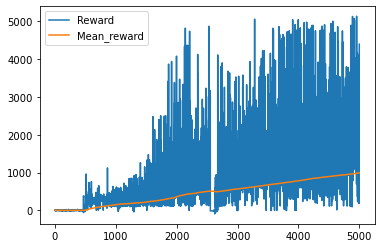

In [10]:

train(env_name = 'Walker2d-v2', seed = 113, iterations = 5000,
      batch_size = 64, memory_size = 500000, min_steps = 10000, 
      updates_per_step = 1, folder = 'walker', hidden = 512, 
      lr = 0.001, tau = 0.05, target_update_int = 1000, alpha = 0.2, gauss = 'Gaussian')

#train(env_name = 'Walker2d-v2', seed = 113,
#      iterations = 5000, batch_size = 64, memory_size = 100000, 
#      min_steps = 5000, updates_per_step = 1, folder = 'human', 
#      hidden = 256, lr = 0.001, tau = 0.5, target_update_int = 1, alpha = 1, gauss = 'Gaussian')

In [6]:
run('Walker2d-v2', 'walker', 'cpu', 512)

/Users/vampire/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/Users/vampire/miniforge3/lib/python3.9/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


Creating window glfw


/var/folders/ts/81qmgdg936qcnxbxr487pm1m0000gn/T/ipykernel_69108/1664167519.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  mean_rewards.append(total_reward/iter)


Episode: 0, total numsteps: 19, episode steps: 19, reward: 95.17
Episode: 1, total numsteps: 49, episode steps: 30, reward: 154.48
Episode: 2, total numsteps: 72, episode steps: 23, reward: 115.24
Episode: 3, total numsteps: 105, episode steps: 33, reward: 169.99
Episode: 4, total numsteps: 122, episode steps: 17, reward: 83.21
Episode: 5, total numsteps: 166, episode steps: 44, reward: 216.43
Episode: 6, total numsteps: 195, episode steps: 29, reward: 152.85
Episode: 7, total numsteps: 216, episode steps: 21, reward: 107.3
Episode: 8, total numsteps: 234, episode steps: 18, reward: 88.97
Episode: 9, total numsteps: 252, episode steps: 18, reward: 89.31
Episode: 10, total numsteps: 280, episode steps: 28, reward: 142.72
Episode: 11, total numsteps: 299, episode steps: 19, reward: 95.29
Episode: 12, total numsteps: 323, episode steps: 24, reward: 120.3
Episode: 13, total numsteps: 342, episode steps: 19, reward: 95.12
Episode: 14, total numsteps: 365, episode steps: 23, reward: 117.68
E

Episode: 121, total numsteps: 2976, episode steps: 23, reward: 118.43
Episode: 122, total numsteps: 2995, episode steps: 19, reward: 94.77
Episode: 123, total numsteps: 3039, episode steps: 44, reward: 224.98
Episode: 124, total numsteps: 3056, episode steps: 17, reward: 83.94
Episode: 125, total numsteps: 3074, episode steps: 18, reward: 88.64
Episode: 126, total numsteps: 3091, episode steps: 17, reward: 83.36
Episode: 127, total numsteps: 3109, episode steps: 18, reward: 88.88
Episode: 128, total numsteps: 3134, episode steps: 25, reward: 126.85
Episode: 129, total numsteps: 3151, episode steps: 17, reward: 83.34
Episode: 130, total numsteps: 3175, episode steps: 24, reward: 124.13
Episode: 131, total numsteps: 3208, episode steps: 33, reward: 162.36
Episode: 132, total numsteps: 3248, episode steps: 40, reward: 202.35
Episode: 133, total numsteps: 3267, episode steps: 19, reward: 95.43
Episode: 134, total numsteps: 3288, episode steps: 21, reward: 102.98
Episode: 135, total numstep

Episode: 239, total numsteps: 6842, episode steps: 50, reward: 274.2
Episode: 240, total numsteps: 6895, episode steps: 53, reward: 290.06
Episode: 241, total numsteps: 6940, episode steps: 45, reward: 245.81
Episode: 242, total numsteps: 6991, episode steps: 51, reward: 281.47
Episode: 243, total numsteps: 7041, episode steps: 50, reward: 272.84
Episode: 244, total numsteps: 7087, episode steps: 46, reward: 251.4
Episode: 245, total numsteps: 7139, episode steps: 52, reward: 279.59
Episode: 246, total numsteps: 7188, episode steps: 49, reward: 265.92
Episode: 247, total numsteps: 7237, episode steps: 49, reward: 269.34
Episode: 248, total numsteps: 7284, episode steps: 47, reward: 255.74
Episode: 249, total numsteps: 7335, episode steps: 51, reward: 278.98
Episode: 250, total numsteps: 7404, episode steps: 69, reward: 372.23
Episode: 251, total numsteps: 7456, episode steps: 52, reward: 282.45
Episode: 252, total numsteps: 7501, episode steps: 45, reward: 238.89
Episode: 253, total nu

Episode: 356, total numsteps: 13188, episode steps: 45, reward: 237.78
Episode: 357, total numsteps: 13237, episode steps: 49, reward: 263.56
Episode: 358, total numsteps: 13284, episode steps: 47, reward: 245.67
Episode: 359, total numsteps: 13336, episode steps: 52, reward: 274.27
Episode: 360, total numsteps: 13387, episode steps: 51, reward: 268.51
Episode: 361, total numsteps: 13446, episode steps: 59, reward: 306.61
Episode: 362, total numsteps: 13505, episode steps: 59, reward: 316.4
Episode: 363, total numsteps: 13555, episode steps: 50, reward: 266.42
Episode: 364, total numsteps: 13621, episode steps: 66, reward: 355.38
Episode: 365, total numsteps: 13667, episode steps: 46, reward: 246.51
Episode: 366, total numsteps: 13717, episode steps: 50, reward: 268.59
Episode: 367, total numsteps: 13771, episode steps: 54, reward: 287.97
Episode: 368, total numsteps: 13852, episode steps: 81, reward: 434.48
Episode: 369, total numsteps: 13948, episode steps: 96, reward: 513.03
Episode

Episode: 472, total numsteps: 20530, episode steps: 50, reward: 259.97
Episode: 473, total numsteps: 20586, episode steps: 56, reward: 299.93
Episode: 474, total numsteps: 20642, episode steps: 56, reward: 310.63
Episode: 475, total numsteps: 20702, episode steps: 60, reward: 322.59
Episode: 476, total numsteps: 20758, episode steps: 56, reward: 306.89
Episode: 477, total numsteps: 20812, episode steps: 54, reward: 288.16
Episode: 478, total numsteps: 20863, episode steps: 51, reward: 280.29
Episode: 479, total numsteps: 20920, episode steps: 57, reward: 315.28
Episode: 480, total numsteps: 20972, episode steps: 52, reward: 287.63
Episode: 481, total numsteps: 21024, episode steps: 52, reward: 286.9
Episode: 482, total numsteps: 21082, episode steps: 58, reward: 325.16
Episode: 483, total numsteps: 21135, episode steps: 53, reward: 285.96
Episode: 484, total numsteps: 21186, episode steps: 51, reward: 277.73
Episode: 485, total numsteps: 21236, episode steps: 50, reward: 273.98
Episode

Episode: 588, total numsteps: 27565, episode steps: 65, reward: 328.44
Episode: 589, total numsteps: 27619, episode steps: 54, reward: 301.56
Episode: 590, total numsteps: 27680, episode steps: 61, reward: 340.39
Episode: 591, total numsteps: 27785, episode steps: 105, reward: 558.67
Episode: 592, total numsteps: 27846, episode steps: 61, reward: 340.45
Episode: 593, total numsteps: 27955, episode steps: 109, reward: 595.12
Episode: 594, total numsteps: 28028, episode steps: 73, reward: 407.17
Episode: 595, total numsteps: 28107, episode steps: 79, reward: 436.89
Episode: 596, total numsteps: 28197, episode steps: 90, reward: 486.15
Episode: 597, total numsteps: 28297, episode steps: 100, reward: 550.95
Episode: 598, total numsteps: 28379, episode steps: 82, reward: 446.01
Episode: 599, total numsteps: 28454, episode steps: 75, reward: 420.04
Episode: 600, total numsteps: 28527, episode steps: 73, reward: 410.54
Episode: 601, total numsteps: 28583, episode steps: 56, reward: 316.28
Epi

Episode: 704, total numsteps: 35237, episode steps: 78, reward: 428.81
Episode: 705, total numsteps: 35308, episode steps: 71, reward: 391.22
Episode: 706, total numsteps: 35394, episode steps: 86, reward: 478.45
Episode: 707, total numsteps: 35462, episode steps: 68, reward: 372.92
Episode: 708, total numsteps: 35527, episode steps: 65, reward: 356.18
Episode: 709, total numsteps: 35616, episode steps: 89, reward: 461.8
Episode: 710, total numsteps: 35687, episode steps: 71, reward: 327.86
Episode: 711, total numsteps: 35750, episode steps: 63, reward: 341.59
Episode: 712, total numsteps: 35847, episode steps: 97, reward: 530.31
Episode: 713, total numsteps: 35914, episode steps: 67, reward: 370.93
Episode: 714, total numsteps: 36046, episode steps: 132, reward: 623.49
Episode: 715, total numsteps: 36119, episode steps: 73, reward: 401.57
Episode: 716, total numsteps: 36184, episode steps: 65, reward: 357.72
Episode: 717, total numsteps: 36275, episode steps: 91, reward: 497.96
Episod

Episode: 820, total numsteps: 43835, episode steps: 97, reward: 487.25
Episode: 821, total numsteps: 43907, episode steps: 72, reward: 354.76
Episode: 822, total numsteps: 43997, episode steps: 90, reward: 440.36
Episode: 823, total numsteps: 44065, episode steps: 68, reward: 354.4
Episode: 824, total numsteps: 44133, episode steps: 68, reward: 334.16
Episode: 825, total numsteps: 44219, episode steps: 86, reward: 472.51
Episode: 826, total numsteps: 44292, episode steps: 73, reward: 388.53
Episode: 827, total numsteps: 44355, episode steps: 63, reward: 307.31
Episode: 828, total numsteps: 44449, episode steps: 94, reward: 497.3
Episode: 829, total numsteps: 44526, episode steps: 77, reward: 413.79
Episode: 830, total numsteps: 44595, episode steps: 69, reward: 383.31
Episode: 831, total numsteps: 44676, episode steps: 81, reward: 424.25
Episode: 832, total numsteps: 44770, episode steps: 94, reward: 450.17
Episode: 833, total numsteps: 44844, episode steps: 74, reward: 360.69
Episode:

Episode: 936, total numsteps: 52631, episode steps: 81, reward: 442.84
Episode: 937, total numsteps: 52743, episode steps: 112, reward: 565.12
Episode: 938, total numsteps: 52809, episode steps: 66, reward: 362.61
Episode: 939, total numsteps: 52878, episode steps: 69, reward: 387.78
Episode: 940, total numsteps: 52953, episode steps: 75, reward: 413.79
Episode: 941, total numsteps: 53028, episode steps: 75, reward: 419.64
Episode: 942, total numsteps: 53100, episode steps: 72, reward: 401.82
Episode: 943, total numsteps: 53176, episode steps: 76, reward: 416.62
Episode: 944, total numsteps: 53246, episode steps: 70, reward: 393.86
Episode: 945, total numsteps: 53310, episode steps: 64, reward: 358.28
Episode: 946, total numsteps: 53386, episode steps: 76, reward: 418.89
Episode: 947, total numsteps: 53455, episode steps: 69, reward: 386.88
Episode: 948, total numsteps: 53532, episode steps: 77, reward: 426.05
Episode: 949, total numsteps: 53615, episode steps: 83, reward: 459.38
Episo

Episode: 1051, total numsteps: 62599, episode steps: 111, reward: 604.37
Episode: 1052, total numsteps: 62699, episode steps: 100, reward: 549.6
Episode: 1053, total numsteps: 62788, episode steps: 89, reward: 494.66
Episode: 1054, total numsteps: 62874, episode steps: 86, reward: 476.82
Episode: 1055, total numsteps: 62953, episode steps: 79, reward: 424.82
Episode: 1056, total numsteps: 63044, episode steps: 91, reward: 502.76
Episode: 1057, total numsteps: 63133, episode steps: 89, reward: 483.94
Episode: 1058, total numsteps: 63210, episode steps: 77, reward: 432.65
Episode: 1059, total numsteps: 63299, episode steps: 89, reward: 495.92
Episode: 1060, total numsteps: 63396, episode steps: 97, reward: 528.98
Episode: 1061, total numsteps: 63481, episode steps: 85, reward: 456.11
Episode: 1062, total numsteps: 63584, episode steps: 103, reward: 564.33
Episode: 1063, total numsteps: 63679, episode steps: 95, reward: 523.73
Episode: 1064, total numsteps: 63830, episode steps: 151, rewa

Episode: 1165, total numsteps: 74229, episode steps: 124, reward: 671.29
Episode: 1166, total numsteps: 74353, episode steps: 124, reward: 662.82
Episode: 1167, total numsteps: 74451, episode steps: 98, reward: 463.88
Episode: 1168, total numsteps: 74578, episode steps: 127, reward: 606.67
Episode: 1169, total numsteps: 74657, episode steps: 79, reward: 378.91
Episode: 1170, total numsteps: 74769, episode steps: 112, reward: 526.01
Episode: 1171, total numsteps: 74856, episode steps: 87, reward: 420.13
Episode: 1172, total numsteps: 74952, episode steps: 96, reward: 452.0
Episode: 1173, total numsteps: 75092, episode steps: 140, reward: 703.99
Episode: 1174, total numsteps: 75218, episode steps: 126, reward: 687.65
Episode: 1175, total numsteps: 75303, episode steps: 85, reward: 421.31
Episode: 1176, total numsteps: 75408, episode steps: 105, reward: 578.07
Episode: 1177, total numsteps: 75499, episode steps: 91, reward: 443.04
Episode: 1178, total numsteps: 75600, episode steps: 101, 

Episode: 1278, total numsteps: 86155, episode steps: 101, reward: 560.53
Episode: 1279, total numsteps: 86252, episode steps: 97, reward: 527.55
Episode: 1280, total numsteps: 86349, episode steps: 97, reward: 534.03
Episode: 1281, total numsteps: 86467, episode steps: 118, reward: 645.64
Episode: 1282, total numsteps: 86585, episode steps: 118, reward: 647.92
Episode: 1283, total numsteps: 86669, episode steps: 84, reward: 457.02
Episode: 1284, total numsteps: 86781, episode steps: 112, reward: 626.71
Episode: 1285, total numsteps: 86893, episode steps: 112, reward: 609.38
Episode: 1286, total numsteps: 87003, episode steps: 110, reward: 613.68
Episode: 1287, total numsteps: 87089, episode steps: 86, reward: 481.3
Episode: 1288, total numsteps: 87189, episode steps: 100, reward: 548.84
Episode: 1289, total numsteps: 87290, episode steps: 101, reward: 523.11
Episode: 1290, total numsteps: 87398, episode steps: 108, reward: 586.76
Episode: 1291, total numsteps: 87502, episode steps: 104

Episode: 1391, total numsteps: 98823, episode steps: 118, reward: 644.01
Episode: 1392, total numsteps: 98962, episode steps: 139, reward: 764.55
Episode: 1393, total numsteps: 99091, episode steps: 129, reward: 702.32
Episode: 1394, total numsteps: 99210, episode steps: 119, reward: 665.12
Episode: 1395, total numsteps: 99348, episode steps: 138, reward: 755.66
Episode: 1396, total numsteps: 99486, episode steps: 138, reward: 755.08
Episode: 1397, total numsteps: 99615, episode steps: 129, reward: 700.99
Episode: 1398, total numsteps: 99790, episode steps: 175, reward: 911.3
Episode: 1399, total numsteps: 99877, episode steps: 87, reward: 478.85
Episode: 1400, total numsteps: 99993, episode steps: 116, reward: 617.32
Episode: 1401, total numsteps: 100089, episode steps: 96, reward: 521.93
Episode: 1402, total numsteps: 100207, episode steps: 118, reward: 650.04
Episode: 1403, total numsteps: 100330, episode steps: 123, reward: 669.03
Episode: 1404, total numsteps: 100467, episode step

Episode: 1503, total numsteps: 112664, episode steps: 96, reward: 523.88
Episode: 1504, total numsteps: 112771, episode steps: 107, reward: 532.58
Episode: 1505, total numsteps: 112933, episode steps: 162, reward: 873.79
Episode: 1506, total numsteps: 113055, episode steps: 122, reward: 634.13
Episode: 1507, total numsteps: 113179, episode steps: 124, reward: 614.65
Episode: 1508, total numsteps: 113311, episode steps: 132, reward: 646.18
Episode: 1509, total numsteps: 113412, episode steps: 101, reward: 535.85
Episode: 1510, total numsteps: 113533, episode steps: 121, reward: 630.98
Episode: 1511, total numsteps: 113657, episode steps: 124, reward: 659.49
Episode: 1512, total numsteps: 113797, episode steps: 140, reward: 769.84
Episode: 1513, total numsteps: 113920, episode steps: 123, reward: 613.02
Episode: 1514, total numsteps: 114032, episode steps: 112, reward: 569.87
Episode: 1515, total numsteps: 114247, episode steps: 215, reward: 1147.45
Episode: 1516, total numsteps: 114453,

Episode: 1614, total numsteps: 127270, episode steps: 101, reward: 547.74
Episode: 1615, total numsteps: 127377, episode steps: 107, reward: 587.31
Episode: 1616, total numsteps: 127518, episode steps: 141, reward: 729.68
Episode: 1617, total numsteps: 127640, episode steps: 122, reward: 680.4
Episode: 1618, total numsteps: 127782, episode steps: 142, reward: 773.8
Episode: 1619, total numsteps: 127991, episode steps: 209, reward: 1132.07
Episode: 1620, total numsteps: 128087, episode steps: 96, reward: 533.33
Episode: 1621, total numsteps: 128225, episode steps: 138, reward: 728.3
Episode: 1622, total numsteps: 128372, episode steps: 147, reward: 764.73
Episode: 1623, total numsteps: 128476, episode steps: 104, reward: 560.98
Episode: 1624, total numsteps: 128562, episode steps: 86, reward: 433.9
Episode: 1625, total numsteps: 128695, episode steps: 133, reward: 729.07
Episode: 1626, total numsteps: 128821, episode steps: 126, reward: 660.2
Episode: 1627, total numsteps: 128928, episo

Episode: 1726, total numsteps: 141804, episode steps: 128, reward: 702.94
Episode: 1727, total numsteps: 141958, episode steps: 154, reward: 857.75
Episode: 1728, total numsteps: 142114, episode steps: 156, reward: 848.06
Episode: 1729, total numsteps: 142237, episode steps: 123, reward: 707.09
Episode: 1730, total numsteps: 142471, episode steps: 234, reward: 1237.43
Episode: 1731, total numsteps: 142564, episode steps: 93, reward: 519.26
Episode: 1732, total numsteps: 142670, episode steps: 106, reward: 593.34
Episode: 1733, total numsteps: 142831, episode steps: 161, reward: 888.98
Episode: 1734, total numsteps: 142952, episode steps: 121, reward: 680.42
Episode: 1735, total numsteps: 143049, episode steps: 97, reward: 528.53
Episode: 1736, total numsteps: 143181, episode steps: 132, reward: 740.37
Episode: 1737, total numsteps: 143348, episode steps: 167, reward: 948.05
Episode: 1738, total numsteps: 143498, episode steps: 150, reward: 833.89
Episode: 1739, total numsteps: 143666, 

Episode: 1837, total numsteps: 158165, episode steps: 228, reward: 1252.75
Episode: 1838, total numsteps: 158288, episode steps: 123, reward: 677.71
Episode: 1839, total numsteps: 158406, episode steps: 118, reward: 662.6
Episode: 1840, total numsteps: 158539, episode steps: 133, reward: 744.82
Episode: 1841, total numsteps: 158760, episode steps: 221, reward: 1214.24
Episode: 1842, total numsteps: 158894, episode steps: 134, reward: 768.99
Episode: 1843, total numsteps: 159031, episode steps: 137, reward: 757.22
Episode: 1844, total numsteps: 159155, episode steps: 124, reward: 699.74
Episode: 1845, total numsteps: 159295, episode steps: 140, reward: 779.33
Episode: 1846, total numsteps: 159386, episode steps: 91, reward: 480.16
Episode: 1847, total numsteps: 159489, episode steps: 103, reward: 581.51
Episode: 1848, total numsteps: 159598, episode steps: 109, reward: 622.89
Episode: 1849, total numsteps: 159691, episode steps: 93, reward: 529.31
Episode: 1850, total numsteps: 159827, 

Episode: 1948, total numsteps: 173894, episode steps: 195, reward: 1091.82
Episode: 1949, total numsteps: 174020, episode steps: 126, reward: 717.24
Episode: 1950, total numsteps: 174169, episode steps: 149, reward: 788.23
Episode: 1951, total numsteps: 174303, episode steps: 134, reward: 749.52
Episode: 1952, total numsteps: 174405, episode steps: 102, reward: 573.68
Episode: 1953, total numsteps: 174601, episode steps: 196, reward: 1063.16
Episode: 1954, total numsteps: 174794, episode steps: 193, reward: 1073.76
Episode: 1955, total numsteps: 174891, episode steps: 97, reward: 546.17
Episode: 1956, total numsteps: 175062, episode steps: 171, reward: 884.62
Episode: 1957, total numsteps: 175165, episode steps: 103, reward: 521.35
Episode: 1958, total numsteps: 175618, episode steps: 453, reward: 2395.06
Episode: 1959, total numsteps: 175808, episode steps: 190, reward: 1045.73
Episode: 1960, total numsteps: 175935, episode steps: 127, reward: 644.36
Episode: 1961, total numsteps: 176

Episode: 2059, total numsteps: 189043, episode steps: 88, reward: 503.72
Episode: 2060, total numsteps: 189146, episode steps: 103, reward: 571.68
Episode: 2061, total numsteps: 189296, episode steps: 150, reward: 752.61
Episode: 2062, total numsteps: 189394, episode steps: 98, reward: 533.26
Episode: 2063, total numsteps: 189532, episode steps: 138, reward: 731.68
Episode: 2064, total numsteps: 189699, episode steps: 167, reward: 896.79
Episode: 2065, total numsteps: 189827, episode steps: 128, reward: 732.99
Episode: 2066, total numsteps: 189939, episode steps: 112, reward: 607.17
Episode: 2067, total numsteps: 190158, episode steps: 219, reward: 1197.3
Episode: 2068, total numsteps: 190275, episode steps: 117, reward: 652.6
Episode: 2069, total numsteps: 190416, episode steps: 141, reward: 805.03
Episode: 2070, total numsteps: 190512, episode steps: 96, reward: 491.73
Episode: 2071, total numsteps: 190714, episode steps: 202, reward: 1048.44
Episode: 2072, total numsteps: 190844, ep

Episode: 2170, total numsteps: 207196, episode steps: 159, reward: 915.23
Episode: 2171, total numsteps: 207410, episode steps: 214, reward: 1154.23
Episode: 2172, total numsteps: 207523, episode steps: 113, reward: 616.53
Episode: 2173, total numsteps: 207679, episode steps: 156, reward: 870.6
Episode: 2174, total numsteps: 207800, episode steps: 121, reward: 677.56
Episode: 2175, total numsteps: 207944, episode steps: 144, reward: 790.32
Episode: 2176, total numsteps: 208189, episode steps: 245, reward: 1373.13
Episode: 2177, total numsteps: 208395, episode steps: 206, reward: 1158.93
Episode: 2178, total numsteps: 208605, episode steps: 210, reward: 1153.82
Episode: 2179, total numsteps: 208804, episode steps: 199, reward: 1072.78
Episode: 2180, total numsteps: 208995, episode steps: 191, reward: 1047.01
Episode: 2181, total numsteps: 209132, episode steps: 137, reward: 768.91
Episode: 2182, total numsteps: 209246, episode steps: 114, reward: 660.26
Episode: 2183, total numsteps: 20

Episode: 2281, total numsteps: 223622, episode steps: 158, reward: 865.7
Episode: 2282, total numsteps: 223799, episode steps: 177, reward: 951.24
Episode: 2283, total numsteps: 223891, episode steps: 92, reward: 537.13
Episode: 2284, total numsteps: 224011, episode steps: 120, reward: 699.3
Episode: 2285, total numsteps: 224191, episode steps: 180, reward: 1006.28
Episode: 2286, total numsteps: 224309, episode steps: 118, reward: 675.59
Episode: 2287, total numsteps: 224501, episode steps: 192, reward: 1145.52
Episode: 2288, total numsteps: 224626, episode steps: 125, reward: 731.65
Episode: 2289, total numsteps: 224843, episode steps: 217, reward: 1215.59
Episode: 2290, total numsteps: 225050, episode steps: 207, reward: 1113.25
Episode: 2291, total numsteps: 225157, episode steps: 107, reward: 603.92
Episode: 2292, total numsteps: 225304, episode steps: 147, reward: 787.23
Episode: 2293, total numsteps: 225402, episode steps: 98, reward: 572.68
Episode: 2294, total numsteps: 225575,

Episode: 2392, total numsteps: 241406, episode steps: 126, reward: 701.06
Episode: 2393, total numsteps: 241642, episode steps: 236, reward: 1177.13
Episode: 2394, total numsteps: 241808, episode steps: 166, reward: 879.4
Episode: 2395, total numsteps: 241965, episode steps: 157, reward: 868.81
Episode: 2396, total numsteps: 242092, episode steps: 127, reward: 746.52
Episode: 2397, total numsteps: 242272, episode steps: 180, reward: 923.46
Episode: 2398, total numsteps: 242363, episode steps: 91, reward: 516.78
Episode: 2399, total numsteps: 242483, episode steps: 120, reward: 688.02
Episode: 2400, total numsteps: 242606, episode steps: 123, reward: 673.98
Episode: 2401, total numsteps: 242741, episode steps: 135, reward: 629.53
Episode: 2402, total numsteps: 242919, episode steps: 178, reward: 998.13
Episode: 2403, total numsteps: 243111, episode steps: 192, reward: 1096.12
Episode: 2404, total numsteps: 243339, episode steps: 228, reward: 1256.67
Episode: 2405, total numsteps: 243532

Episode: 2503, total numsteps: 261128, episode steps: 367, reward: 2115.09
Episode: 2504, total numsteps: 261363, episode steps: 235, reward: 1297.67
Episode: 2505, total numsteps: 261557, episode steps: 194, reward: 1075.76
Episode: 2506, total numsteps: 261718, episode steps: 161, reward: 796.55
Episode: 2507, total numsteps: 261819, episode steps: 101, reward: 581.13
Episode: 2508, total numsteps: 262350, episode steps: 531, reward: 3086.14
Episode: 2509, total numsteps: 262521, episode steps: 171, reward: 975.58
Episode: 2510, total numsteps: 262718, episode steps: 197, reward: 1013.56
Episode: 2511, total numsteps: 262901, episode steps: 183, reward: 1056.41
Episode: 2512, total numsteps: 263054, episode steps: 153, reward: 862.83
Episode: 2513, total numsteps: 263270, episode steps: 216, reward: 1225.28
Episode: 2514, total numsteps: 263428, episode steps: 158, reward: 890.3
Episode: 2515, total numsteps: 263595, episode steps: 167, reward: 950.52
Episode: 2516, total numsteps: 2

Episode: 2614, total numsteps: 282381, episode steps: 124, reward: 697.14
Episode: 2615, total numsteps: 282594, episode steps: 213, reward: 1161.22
Episode: 2616, total numsteps: 282904, episode steps: 310, reward: 1747.37
Episode: 2617, total numsteps: 283106, episode steps: 202, reward: 1095.55
Episode: 2618, total numsteps: 283322, episode steps: 216, reward: 1123.39
Episode: 2619, total numsteps: 283482, episode steps: 160, reward: 916.52
Episode: 2620, total numsteps: 283665, episode steps: 183, reward: 962.33
Episode: 2621, total numsteps: 283811, episode steps: 146, reward: 810.18
Episode: 2622, total numsteps: 284116, episode steps: 305, reward: 1705.18
Episode: 2623, total numsteps: 284414, episode steps: 298, reward: 1644.13
Episode: 2624, total numsteps: 284543, episode steps: 129, reward: 749.5
Episode: 2625, total numsteps: 284787, episode steps: 244, reward: 1407.89
Episode: 2626, total numsteps: 284988, episode steps: 201, reward: 1066.07
Episode: 2627, total numsteps: 

Episode: 2725, total numsteps: 305372, episode steps: 220, reward: 1168.9
Episode: 2726, total numsteps: 305517, episode steps: 145, reward: 805.66
Episode: 2727, total numsteps: 305729, episode steps: 212, reward: 1139.45
Episode: 2728, total numsteps: 305966, episode steps: 237, reward: 1272.51
Episode: 2729, total numsteps: 306193, episode steps: 227, reward: 1207.67
Episode: 2730, total numsteps: 306270, episode steps: 77, reward: 418.95
Episode: 2731, total numsteps: 306362, episode steps: 92, reward: 527.86
Episode: 2732, total numsteps: 306630, episode steps: 268, reward: 1435.25
Episode: 2733, total numsteps: 306815, episode steps: 185, reward: 1039.65
Episode: 2734, total numsteps: 306943, episode steps: 128, reward: 708.42
Episode: 2735, total numsteps: 307167, episode steps: 224, reward: 1223.37
Episode: 2736, total numsteps: 307346, episode steps: 179, reward: 1014.6
Episode: 2737, total numsteps: 307616, episode steps: 270, reward: 1416.28
Episode: 2738, total numsteps: 30

Episode: 2835, total numsteps: 331684, episode steps: 268, reward: 1473.25
Episode: 2836, total numsteps: 331828, episode steps: 144, reward: 681.85
Episode: 2837, total numsteps: 332086, episode steps: 258, reward: 1284.27
Episode: 2838, total numsteps: 332313, episode steps: 227, reward: 1228.15
Episode: 2839, total numsteps: 332601, episode steps: 288, reward: 1649.15
Episode: 2840, total numsteps: 332709, episode steps: 108, reward: 618.18
Episode: 2841, total numsteps: 332925, episode steps: 216, reward: 1153.67
Episode: 2842, total numsteps: 333090, episode steps: 165, reward: 887.42
Episode: 2843, total numsteps: 333335, episode steps: 245, reward: 1273.73
Episode: 2844, total numsteps: 333544, episode steps: 209, reward: 1154.44
Episode: 2845, total numsteps: 333611, episode steps: 67, reward: 382.06
Episode: 2846, total numsteps: 333675, episode steps: 64, reward: 358.01
Episode: 2847, total numsteps: 333993, episode steps: 318, reward: 1666.9
Episode: 2848, total numsteps: 33

Episode: 2945, total numsteps: 357906, episode steps: 472, reward: 2706.42
Episode: 2946, total numsteps: 358172, episode steps: 266, reward: 1370.38
Episode: 2947, total numsteps: 358492, episode steps: 320, reward: 1813.77
Episode: 2948, total numsteps: 358931, episode steps: 439, reward: 2510.92
Episode: 2949, total numsteps: 359318, episode steps: 387, reward: 2129.82
Episode: 2950, total numsteps: 359992, episode steps: 674, reward: 3744.19
Episode: 2951, total numsteps: 360335, episode steps: 343, reward: 1930.39
Episode: 2952, total numsteps: 360581, episode steps: 246, reward: 1384.23
Episode: 2953, total numsteps: 360693, episode steps: 112, reward: 654.41
Episode: 2954, total numsteps: 360869, episode steps: 176, reward: 1023.75
Episode: 2955, total numsteps: 361291, episode steps: 422, reward: 2378.22
Episode: 2956, total numsteps: 361624, episode steps: 333, reward: 1819.48
Episode: 2957, total numsteps: 362226, episode steps: 602, reward: 3428.19
Episode: 2958, total numst

Episode: 3055, total numsteps: 386266, episode steps: 161, reward: 939.64
Episode: 3056, total numsteps: 386503, episode steps: 237, reward: 1308.51
Episode: 3057, total numsteps: 386676, episode steps: 173, reward: 973.18
Episode: 3058, total numsteps: 387496, episode steps: 820, reward: 4586.08
Episode: 3059, total numsteps: 387740, episode steps: 244, reward: 1383.74
Episode: 3060, total numsteps: 387940, episode steps: 200, reward: 1132.67
Episode: 3061, total numsteps: 388190, episode steps: 250, reward: 1366.11
Episode: 3062, total numsteps: 388479, episode steps: 289, reward: 1557.76
Episode: 3063, total numsteps: 389143, episode steps: 664, reward: 3868.72
Episode: 3064, total numsteps: 389556, episode steps: 413, reward: 2330.72
Episode: 3065, total numsteps: 389701, episode steps: 145, reward: 849.33
Episode: 3066, total numsteps: 390176, episode steps: 475, reward: 2604.82
Episode: 3067, total numsteps: 390305, episode steps: 129, reward: 738.83
Episode: 3068, total numsteps

Episode: 3165, total numsteps: 414542, episode steps: 91, reward: 520.41
Episode: 3166, total numsteps: 414667, episode steps: 125, reward: 730.38
Episode: 3167, total numsteps: 415518, episode steps: 851, reward: 4518.46
Episode: 3168, total numsteps: 415828, episode steps: 310, reward: 1762.37
Episode: 3169, total numsteps: 416208, episode steps: 380, reward: 2056.88
Episode: 3170, total numsteps: 416553, episode steps: 345, reward: 1976.11
Episode: 3171, total numsteps: 416987, episode steps: 434, reward: 2358.67
Episode: 3172, total numsteps: 417223, episode steps: 236, reward: 1353.28
Episode: 3173, total numsteps: 417533, episode steps: 310, reward: 1667.03
Episode: 3174, total numsteps: 417750, episode steps: 217, reward: 1218.44
Episode: 3175, total numsteps: 417935, episode steps: 185, reward: 1001.11
Episode: 3176, total numsteps: 418157, episode steps: 222, reward: 1153.21
Episode: 3177, total numsteps: 418467, episode steps: 310, reward: 1737.75
Episode: 3178, total numstep

Episode: 3275, total numsteps: 445053, episode steps: 295, reward: 1535.36
Episode: 3276, total numsteps: 445243, episode steps: 190, reward: 992.02
Episode: 3277, total numsteps: 445316, episode steps: 73, reward: 427.61
Episode: 3278, total numsteps: 445899, episode steps: 583, reward: 3086.07
Episode: 3279, total numsteps: 446170, episode steps: 271, reward: 1512.88
Episode: 3280, total numsteps: 446888, episode steps: 718, reward: 4077.6
Episode: 3281, total numsteps: 447262, episode steps: 374, reward: 1945.02
Episode: 3282, total numsteps: 447490, episode steps: 228, reward: 1251.25
Episode: 3283, total numsteps: 447927, episode steps: 437, reward: 2418.65
Episode: 3284, total numsteps: 448190, episode steps: 263, reward: 1436.73
Episode: 3285, total numsteps: 448438, episode steps: 248, reward: 1274.02
Episode: 3286, total numsteps: 448700, episode steps: 262, reward: 1358.62
Episode: 3287, total numsteps: 449377, episode steps: 677, reward: 3796.42
Episode: 3288, total numsteps

Episode: 3385, total numsteps: 485912, episode steps: 319, reward: 1830.79
Episode: 3386, total numsteps: 486134, episode steps: 222, reward: 1254.9
Episode: 3387, total numsteps: 486442, episode steps: 308, reward: 1699.05
Episode: 3388, total numsteps: 486901, episode steps: 459, reward: 2547.06
Episode: 3389, total numsteps: 487044, episode steps: 143, reward: 810.29
Episode: 3390, total numsteps: 487578, episode steps: 534, reward: 2911.24
Episode: 3391, total numsteps: 487747, episode steps: 169, reward: 934.92
Episode: 3392, total numsteps: 487939, episode steps: 192, reward: 1185.78
Episode: 3393, total numsteps: 488594, episode steps: 655, reward: 3633.4
Episode: 3394, total numsteps: 488894, episode steps: 300, reward: 1619.5
Episode: 3395, total numsteps: 489396, episode steps: 502, reward: 2839.27
Episode: 3396, total numsteps: 489668, episode steps: 272, reward: 1563.62
Episode: 3397, total numsteps: 489777, episode steps: 109, reward: 641.14
Episode: 3398, total numsteps: 

Episode: 3495, total numsteps: 523610, episode steps: 402, reward: 2195.99
Episode: 3496, total numsteps: 523721, episode steps: 111, reward: 667.47
Episode: 3497, total numsteps: 523788, episode steps: 67, reward: 377.18
Episode: 3498, total numsteps: 523990, episode steps: 202, reward: 1114.08
Episode: 3499, total numsteps: 524074, episode steps: 84, reward: 481.14
Episode: 3500, total numsteps: 524171, episode steps: 97, reward: 577.95
Episode: 3501, total numsteps: 524706, episode steps: 535, reward: 2805.29
Episode: 3502, total numsteps: 525368, episode steps: 662, reward: 3739.31
Episode: 3503, total numsteps: 526010, episode steps: 642, reward: 3534.35
Episode: 3504, total numsteps: 526142, episode steps: 132, reward: 642.52
Episode: 3505, total numsteps: 526551, episode steps: 409, reward: 2294.61
Episode: 3506, total numsteps: 527154, episode steps: 603, reward: 3398.76
Episode: 3507, total numsteps: 527317, episode steps: 163, reward: 911.93
Episode: 3508, total numsteps: 527

Episode: 3606, total numsteps: 557866, episode steps: 408, reward: 2183.47
Episode: 3607, total numsteps: 558274, episode steps: 408, reward: 2389.34
Episode: 3608, total numsteps: 558439, episode steps: 165, reward: 996.04
Episode: 3609, total numsteps: 558531, episode steps: 92, reward: 528.13
Episode: 3610, total numsteps: 558651, episode steps: 120, reward: 721.56
Episode: 3611, total numsteps: 559651, episode steps: 1000, reward: 5677.84
Episode: 3612, total numsteps: 560443, episode steps: 792, reward: 4563.56
Episode: 3613, total numsteps: 560632, episode steps: 189, reward: 1118.27
Episode: 3614, total numsteps: 561632, episode steps: 1000, reward: 5916.54
Episode: 3615, total numsteps: 561950, episode steps: 318, reward: 1787.78
Episode: 3616, total numsteps: 562437, episode steps: 487, reward: 2860.72
Episode: 3617, total numsteps: 562585, episode steps: 148, reward: 845.11
Episode: 3618, total numsteps: 563023, episode steps: 438, reward: 2583.36
Episode: 3619, total numstep

Episode: 3716, total numsteps: 600676, episode steps: 439, reward: 2640.83
Episode: 3717, total numsteps: 600929, episode steps: 253, reward: 1365.24
Episode: 3718, total numsteps: 601069, episode steps: 140, reward: 838.2
Episode: 3719, total numsteps: 601903, episode steps: 834, reward: 4932.8
Episode: 3720, total numsteps: 602545, episode steps: 642, reward: 3573.57
Episode: 3721, total numsteps: 603002, episode steps: 457, reward: 2489.93
Episode: 3722, total numsteps: 603216, episode steps: 214, reward: 1294.43
Episode: 3723, total numsteps: 603526, episode steps: 310, reward: 1779.52
Episode: 3724, total numsteps: 603700, episode steps: 174, reward: 974.14
Episode: 3725, total numsteps: 603806, episode steps: 106, reward: 626.12
Episode: 3726, total numsteps: 604315, episode steps: 509, reward: 3043.71
Episode: 3727, total numsteps: 604556, episode steps: 241, reward: 1419.8
Episode: 3728, total numsteps: 604685, episode steps: 129, reward: 772.15
Episode: 3729, total numsteps: 6

Episode: 3826, total numsteps: 639624, episode steps: 634, reward: 3635.52
Episode: 3827, total numsteps: 639986, episode steps: 362, reward: 2015.94
Episode: 3828, total numsteps: 640097, episode steps: 111, reward: 666.62
Episode: 3829, total numsteps: 641097, episode steps: 1000, reward: 5955.09
Episode: 3830, total numsteps: 641740, episode steps: 643, reward: 3657.43
Episode: 3831, total numsteps: 642029, episode steps: 289, reward: 1534.34
Episode: 3832, total numsteps: 643029, episode steps: 1000, reward: 5684.84
Episode: 3833, total numsteps: 644029, episode steps: 1000, reward: 5733.51
Episode: 3834, total numsteps: 645029, episode steps: 1000, reward: 5858.75
Episode: 3835, total numsteps: 645555, episode steps: 526, reward: 3056.73
Episode: 3836, total numsteps: 645775, episode steps: 220, reward: 1238.17
Episode: 3837, total numsteps: 646775, episode steps: 1000, reward: 5698.82
Episode: 3838, total numsteps: 647042, episode steps: 267, reward: 1456.55
Episode: 3839, total 

Episode: 3936, total numsteps: 692529, episode steps: 206, reward: 1243.31
Episode: 3937, total numsteps: 693529, episode steps: 1000, reward: 5935.68
Episode: 3938, total numsteps: 694376, episode steps: 847, reward: 4930.25
Episode: 3939, total numsteps: 694998, episode steps: 622, reward: 3672.18
Episode: 3940, total numsteps: 695809, episode steps: 811, reward: 4588.26
Episode: 3941, total numsteps: 696567, episode steps: 758, reward: 4357.12
Episode: 3942, total numsteps: 697567, episode steps: 1000, reward: 5974.17
Episode: 3943, total numsteps: 698091, episode steps: 524, reward: 3032.47
Episode: 3944, total numsteps: 698389, episode steps: 298, reward: 1633.27
Episode: 3945, total numsteps: 699389, episode steps: 1000, reward: 5700.36
Episode: 3946, total numsteps: 699474, episode steps: 85, reward: 501.58
Episode: 3947, total numsteps: 700474, episode steps: 1000, reward: 5942.53
Episode: 3948, total numsteps: 701346, episode steps: 872, reward: 5288.15
Episode: 3949, total nu

Episode: 4046, total numsteps: 757130, episode steps: 338, reward: 2021.22
Episode: 4047, total numsteps: 758130, episode steps: 1000, reward: 6262.37
Episode: 4048, total numsteps: 759130, episode steps: 1000, reward: 6207.14
Episode: 4049, total numsteps: 759610, episode steps: 480, reward: 2917.97
Episode: 4050, total numsteps: 760127, episode steps: 517, reward: 3188.92
Episode: 4051, total numsteps: 760541, episode steps: 414, reward: 2532.96
Episode: 4052, total numsteps: 760860, episode steps: 319, reward: 1957.85
Episode: 4053, total numsteps: 761105, episode steps: 245, reward: 1496.95
Episode: 4054, total numsteps: 761528, episode steps: 423, reward: 2621.25
Episode: 4055, total numsteps: 761660, episode steps: 132, reward: 763.82
Episode: 4056, total numsteps: 762118, episode steps: 458, reward: 2876.23
Episode: 4057, total numsteps: 762306, episode steps: 188, reward: 1102.23
Episode: 4058, total numsteps: 762484, episode steps: 178, reward: 1071.99
Episode: 4059, total num

Episode: 4156, total numsteps: 815214, episode steps: 153, reward: 820.76
Episode: 4157, total numsteps: 815453, episode steps: 239, reward: 1492.39
Episode: 4158, total numsteps: 815792, episode steps: 339, reward: 2168.82
Episode: 4159, total numsteps: 816792, episode steps: 1000, reward: 6131.86
Episode: 4160, total numsteps: 817709, episode steps: 917, reward: 5912.75
Episode: 4161, total numsteps: 818709, episode steps: 1000, reward: 6686.99
Episode: 4162, total numsteps: 819121, episode steps: 412, reward: 2507.85
Episode: 4163, total numsteps: 819258, episode steps: 137, reward: 867.8
Episode: 4164, total numsteps: 819694, episode steps: 436, reward: 2606.84
Episode: 4165, total numsteps: 820073, episode steps: 379, reward: 2351.87
Episode: 4166, total numsteps: 820779, episode steps: 706, reward: 4321.83
Episode: 4167, total numsteps: 821006, episode steps: 227, reward: 1434.97
Episode: 4168, total numsteps: 821190, episode steps: 184, reward: 1114.21
Episode: 4169, total numst

Episode: 4266, total numsteps: 874987, episode steps: 576, reward: 3760.13
Episode: 4267, total numsteps: 875987, episode steps: 1000, reward: 6410.51
Episode: 4268, total numsteps: 876987, episode steps: 1000, reward: 6483.21
Episode: 4269, total numsteps: 877767, episode steps: 780, reward: 5065.61
Episode: 4270, total numsteps: 878110, episode steps: 343, reward: 2179.83
Episode: 4271, total numsteps: 878762, episode steps: 652, reward: 4251.79
Episode: 4272, total numsteps: 878929, episode steps: 167, reward: 887.04
Episode: 4273, total numsteps: 879929, episode steps: 1000, reward: 6472.89
Episode: 4274, total numsteps: 880262, episode steps: 333, reward: 2138.91
Episode: 4275, total numsteps: 880463, episode steps: 201, reward: 1287.73
Episode: 4276, total numsteps: 880876, episode steps: 413, reward: 2645.46
Episode: 4277, total numsteps: 881876, episode steps: 1000, reward: 6612.34
Episode: 4278, total numsteps: 882036, episode steps: 160, reward: 968.26
Episode: 4279, total nu

Episode: 4375, total numsteps: 947470, episode steps: 1000, reward: 6549.73
Episode: 4376, total numsteps: 948347, episode steps: 877, reward: 5863.13
Episode: 4377, total numsteps: 949244, episode steps: 897, reward: 5973.05
Episode: 4378, total numsteps: 949590, episode steps: 346, reward: 2166.64
Episode: 4379, total numsteps: 949914, episode steps: 324, reward: 2171.91
Episode: 4380, total numsteps: 950125, episode steps: 211, reward: 1280.95
Episode: 4381, total numsteps: 950824, episode steps: 699, reward: 4597.74
Episode: 4382, total numsteps: 951158, episode steps: 334, reward: 2160.17
Episode: 4383, total numsteps: 951673, episode steps: 515, reward: 3155.14
Episode: 4384, total numsteps: 952369, episode steps: 696, reward: 4429.26
Episode: 4385, total numsteps: 952455, episode steps: 86, reward: 495.97
Episode: 4386, total numsteps: 952840, episode steps: 385, reward: 2470.52
Episode: 4387, total numsteps: 952994, episode steps: 154, reward: 928.91
Episode: 4388, total numste

Episode: 4484, total numsteps: 1017089, episode steps: 1000, reward: 6491.64
Episode: 4485, total numsteps: 1017485, episode steps: 396, reward: 2459.72
Episode: 4486, total numsteps: 1018289, episode steps: 804, reward: 5093.45
Episode: 4487, total numsteps: 1019289, episode steps: 1000, reward: 6391.75
Episode: 4488, total numsteps: 1019374, episode steps: 85, reward: 444.49
Episode: 4489, total numsteps: 1019513, episode steps: 139, reward: 736.11
Episode: 4490, total numsteps: 1020513, episode steps: 1000, reward: 6402.58
Episode: 4491, total numsteps: 1020768, episode steps: 255, reward: 1477.64
Episode: 4492, total numsteps: 1021160, episode steps: 392, reward: 2529.91
Episode: 4493, total numsteps: 1021515, episode steps: 355, reward: 2196.02
Episode: 4494, total numsteps: 1022076, episode steps: 561, reward: 3418.55
Episode: 4495, total numsteps: 1022265, episode steps: 189, reward: 1169.69
Episode: 4496, total numsteps: 1023060, episode steps: 795, reward: 5033.38
Episode: 449

Episode: 4592, total numsteps: 1094287, episode steps: 158, reward: 1039.15
Episode: 4593, total numsteps: 1095287, episode steps: 1000, reward: 6581.0
Episode: 4594, total numsteps: 1096287, episode steps: 1000, reward: 6670.73
Episode: 4595, total numsteps: 1097267, episode steps: 980, reward: 6562.87
Episode: 4596, total numsteps: 1098267, episode steps: 1000, reward: 6611.7
Episode: 4597, total numsteps: 1098625, episode steps: 358, reward: 2371.89
Episode: 4598, total numsteps: 1099625, episode steps: 1000, reward: 6654.07
Episode: 4599, total numsteps: 1100625, episode steps: 1000, reward: 6643.32
Episode: 4600, total numsteps: 1101087, episode steps: 462, reward: 2966.55
Episode: 4601, total numsteps: 1102048, episode steps: 961, reward: 6422.11
Episode: 4602, total numsteps: 1103048, episode steps: 1000, reward: 6736.99
Episode: 4603, total numsteps: 1104048, episode steps: 1000, reward: 6711.44
Episode: 4604, total numsteps: 1105048, episode steps: 1000, reward: 6736.42
Episod

Episode: 4700, total numsteps: 1175280, episode steps: 193, reward: 1197.62
Episode: 4701, total numsteps: 1176280, episode steps: 1000, reward: 6699.41
Episode: 4702, total numsteps: 1176344, episode steps: 64, reward: 369.32
Episode: 4703, total numsteps: 1176383, episode steps: 39, reward: 214.75
Episode: 4704, total numsteps: 1176431, episode steps: 48, reward: 274.25
Episode: 4705, total numsteps: 1176624, episode steps: 193, reward: 1256.48
Episode: 4706, total numsteps: 1177232, episode steps: 608, reward: 3939.17
Episode: 4707, total numsteps: 1178232, episode steps: 1000, reward: 6624.55
Episode: 4708, total numsteps: 1179039, episode steps: 807, reward: 5312.03
Episode: 4709, total numsteps: 1179271, episode steps: 232, reward: 1468.7
Episode: 4710, total numsteps: 1180271, episode steps: 1000, reward: 6621.16
Episode: 4711, total numsteps: 1181271, episode steps: 1000, reward: 6672.68
Episode: 4712, total numsteps: 1181662, episode steps: 391, reward: 2452.33
Episode: 4713, 

Episode: 4808, total numsteps: 1246313, episode steps: 1000, reward: 6965.57
Episode: 4809, total numsteps: 1247313, episode steps: 1000, reward: 6816.08
Episode: 4810, total numsteps: 1248313, episode steps: 1000, reward: 6736.47
Episode: 4811, total numsteps: 1249313, episode steps: 1000, reward: 6786.9
Episode: 4812, total numsteps: 1250255, episode steps: 942, reward: 6195.24
Episode: 4813, total numsteps: 1250807, episode steps: 552, reward: 3708.4
Episode: 4814, total numsteps: 1251807, episode steps: 1000, reward: 6919.42
Episode: 4815, total numsteps: 1252349, episode steps: 542, reward: 3622.08
Episode: 4816, total numsteps: 1253349, episode steps: 1000, reward: 6764.27
Episode: 4817, total numsteps: 1254349, episode steps: 1000, reward: 6773.87
Episode: 4818, total numsteps: 1254480, episode steps: 131, reward: 723.52
Episode: 4819, total numsteps: 1254864, episode steps: 384, reward: 2591.59
Episode: 4820, total numsteps: 1255771, episode steps: 907, reward: 6184.15
Episode:

Episode: 4916, total numsteps: 1315479, episode steps: 1000, reward: 6831.84
Episode: 4917, total numsteps: 1316479, episode steps: 1000, reward: 6853.7
Episode: 4918, total numsteps: 1317479, episode steps: 1000, reward: 6755.02
Episode: 4919, total numsteps: 1317891, episode steps: 412, reward: 2735.69
Episode: 4920, total numsteps: 1318891, episode steps: 1000, reward: 6792.1
Episode: 4921, total numsteps: 1319769, episode steps: 878, reward: 5958.44
Episode: 4922, total numsteps: 1320132, episode steps: 363, reward: 2448.86
Episode: 4923, total numsteps: 1320304, episode steps: 172, reward: 1136.73
Episode: 4924, total numsteps: 1321304, episode steps: 1000, reward: 6736.46
Episode: 4925, total numsteps: 1322304, episode steps: 1000, reward: 6791.68
Episode: 4926, total numsteps: 1323304, episode steps: 1000, reward: 6928.99
Episode: 4927, total numsteps: 1324304, episode steps: 1000, reward: 6887.0
Episode: 4928, total numsteps: 1324782, episode steps: 478, reward: 3208.61
Episode

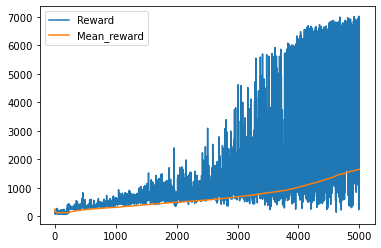

In [6]:
#env_name, seed, iterations, batch_size, memory_size, min_steps, updates_per_step, folder, 
#          hidden, lr, tau, target_update_int, alpha, gauss
train(env_name = 'Humanoid-v4', seed = 113,
      iterations = 5000, batch_size = 64, memory_size = 100000, 
      min_steps = 5000, updates_per_step = 1, folder = 'human', 
      hidden = 256, lr = 0.001, tau = 0.5, target_update_int = 1, alpha = 1, gauss = 'Gaussian')

In [ ]:
run('Humanoid-v4', 'human', 'cpu', 256)